# EDA Binary Classification with a Bank Dataset

### This EDA refers to Kaggle playground competition: "Binary Classification with a Bank Dataset" 
- Competition link: https://www.kaggle.com/competitions/playground-series-s5e8
- Main goal of this competition is to predict whether a client will subscribe to a bank term deposit.
- Submissions are evaluated using ROC AUC between the predicted value and the observed target.
- The dataset for this competition (both train and test) was generated from a deep learning model trained on the Bank Marketing Dataset dataset. Feature distributions are close to, but not exactly the same, as the original.
- Start Date - August 1, 2025
- Final Submission Deadline - August 31, 2025

### Labels detail from original data set

- age: Age of the client (numeric)
- job: Type of job (categorical: "admin.", "blue-collar", "entrepreneur", etc.)
- marital: Marital status (categorical: "married", "single", "divorced")
- education: Level of education (categorical: "primary", "secondary", "tertiary", "unknown")
- default: Has credit in default? (categorical: "yes", "no")
- balance: Average yearly balance in euros (numeric)
- housing: Has a housing loan? (categorical: "yes", "no")
- loan: Has a personal loan? (categorical: "yes", "no")
- contact: Type of communication contact (categorical: "unknown", "telephone", "cellular")
- day: Last contact day of the month (numeric, 1-31)
- month: Last contact month of the year (categorical: "jan", "feb", "mar", …, "dec")
- duration: Last contact duration in seconds (numeric)
- campaign: Number of contacts performed during this campaign (numeric)
- pdays: Number of days since the client was last contacted from a previous campaign (numeric; -1 means the client was not previously contacted)
- previous: Number of contacts performed before this campaign (numeric)
- poutcome: Outcome of the previous marketing campaign (categorical: "unknown", "other", "failure", "success")
- y: The target variable, whether the client subscribed to a term deposit

In [123]:
import numpy as np 
import pandas as pd 
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor, LGBMClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.manifold import TSNE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

warnings.filterwarnings("ignore",  category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning,)
warnings.filterwarnings("ignore", category=UserWarning)


In [124]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv')
sub_df = pd.read_csv('/kaggle/input/playground-series-s5e8/sample_submission.csv')

## 1. Basic check of data

In [125]:
display(train_df.head(4))
display(test_df.head(4))

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown


In [126]:
display(train_df.info())
display(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         250000 non-null  int64 
 1   age        250000 non-null  int64 
 2   job        250000 non-null  object
 3   marital    250000 non-null  object
 4   education  250000 non-null  object
 5   default    250000 non-null  object
 6   balance    250000 non-null  int64 
 7   housing    250000 non-null  object
 8   loan       250000 non-null  object
 9   contact    250000 non-null  object
 10  day        250000 non-null  int64 
 11  month      250000 non-null  object
 12  duration   250000 non-null  int64 
 13  campaign   250000 non-null  int64 
 14  pdays      250000 non-null  int64 
 15  previous   250000 non-null  int64 
 16  poutcome   250000 non-null  object
dtypes: int64(8), object(9)
memory usage: 32.4+ MB


None

In [127]:
display("Summary for TRAIN data:",train_df.describe())
display("Summary for TEST data:",test_df.describe())

'Summary for TRAIN data:'

,id,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,216506.495284,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,0.000000,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,187499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,374999.500000,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,562499.250000,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,749999.000000,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


'Summary for TEST data:'

,id,age,balance,day,duration,campaign,pdays,previous
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,874999.500000,40.932332,1197.426352,16.116068,255.342260,2.573548,22.280028,0.303728
std,72168.927986,10.081613,2741.520699,8.258509,271.404326,2.709661,76.915879,1.384574
min,750000.000000,18.000000,-8019.000000,1.000000,3.000000,1.000000,-1.000000,0.000000
25%,812499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000
50%,874999.500000,39.000000,631.000000,17.000000,133.000000,2.000000,-1.000000,0.000000
75%,937499.250000,48.000000,1389.000000,21.000000,353.000000,3.000000,-1.000000,0.000000
max,999999.000000,95.000000,98517.000000,31.000000,4918.000000,58.000000,871.000000,150.000000


In [128]:
display("TRAIN data", train_df.nunique())
print('\n')
display('TEST data',test_df.nunique())

'TRAIN data'

id           750000
age              78
job              12
marital           3
education         4
default           2
balance        8217
housing           2
loan              2
contact           3
day              31
month            12
duration       1760
campaign         52
pdays           596
previous         50
poutcome          4
y                 2
dtype: int64

'TEST data'

id           250000
age              76
job              12
marital           3
education         4
default           2
balance        7073
housing           2
loan              2
contact           3
day              31
month            12
duration       1620
campaign         49
pdays           518
previous         47
poutcome          4
dtype: int64

### Key Observations:
- We have 7 numeric columns and 9 with categories
- month column can be mapped to numerical column if needed
- One coulmn with id in both train/test sets and additional column with labels in train set
- number of unique values different for columns age, balance, duration, campaign, pdays, previous
- min values different for train - test set for column duration
- max values different balance, campaign, previous
- pdays have two separate information - first number of days and second == -1 means the client was not previously contacted. Can be separated into two columns to separate category from numeric

### BONUS: Dimensions reduction with t-SNE & visualization 

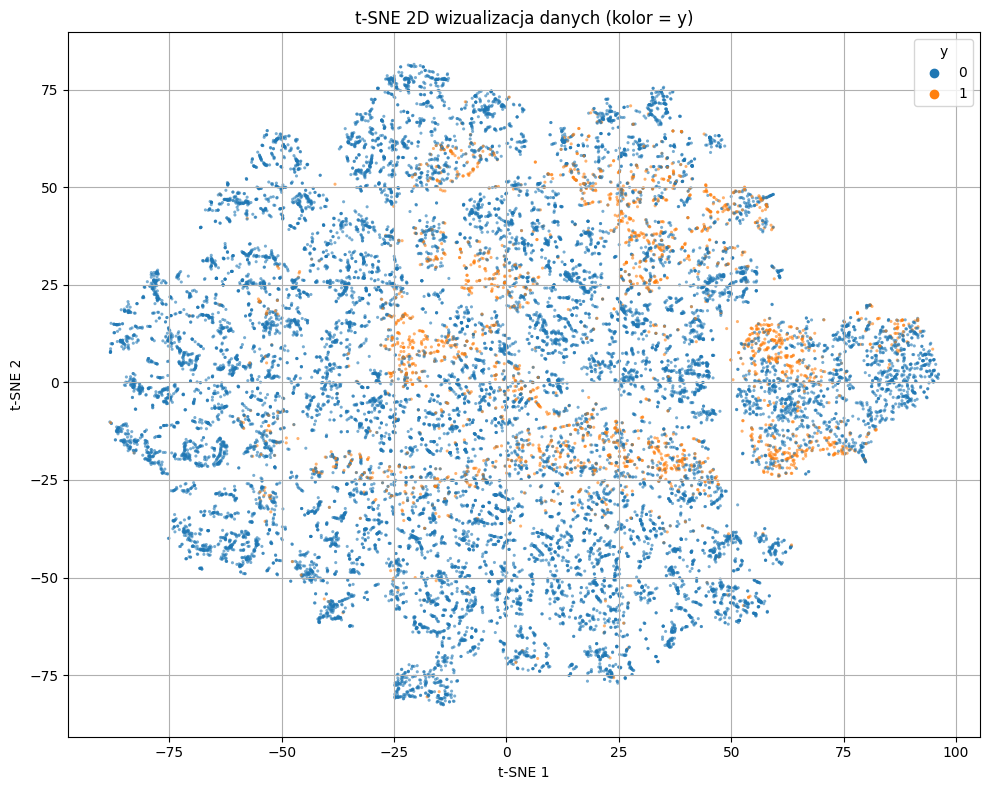

In [129]:
X = train_df.drop(columns=['id', 'y'])
y = train_df['y']

# Separation of numeric and categorical columns
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Pipeline: przetwarzanie cech
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_cols)
])

X_processed = preprocessor.fit_transform(X)

# Dimensions reduction with t-SNE
# t-SNE is very slow for large datasets. We will check only 20k random samples
SAMPLE_SIZE = 20000

idx = np.random.choice(len(X_processed), SAMPLE_SIZE, replace=False)
X_sample = X_processed[idx]
y_sample = y.iloc[idx]

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_sample)


# Creating plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=y_sample,
#    palette='coolwarm',
    s=5,
    alpha=0.6,
    linewidth=0
)
plt.title("t-SNE 2D wizualizacja danych (kolor = y)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title='y')
plt.grid(True)
plt.tight_layout()
plt.show()

### BONUS - Separation of pdays and additional column with months as numeric

In [130]:
# we can create separate column with flag for -1 value
train_df['no_previous_contact'] = (train_df['pdays'] == -1).astype(int)
test_df['no_previous_contact'] = (test_df['pdays'] == -1).astype(int)

# We can create additional column with pdays only without -1 values
train_df['pdays_cleaned'] = train_df['pdays'].where(train_df['pdays'] != -1, np.nan) 
test_df['pdays_cleaned'] = test_df['pdays'].where(test_df['pdays'] != -1, np.nan) 

# We can create additional column with numeric months
train_df['month_as_num'] = train_df['month'].map({'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11, 'dec':12})
test_df['month_as_num'] = test_df['month'].map({'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11, 'dec':12})

## 2. Duplicates and missing values check

In [131]:
print("Duplicates in TRAIN data:", train_df.duplicated().sum())
print("Duplicates in TEST data:", test_df.duplicated().sum())

Duplicates in TRAIN data: 0
Duplicates in TEST data: 0


In [132]:
print("Missing values in TRAIN data:\n",train_df.isna().mean().apply(lambda x: f"{x:.2%}"))
print("\nMissing values  in TEST data:\n",test_df.isna().mean().apply(lambda x: f"{x:.2%}"))

Missing values in TRAIN data:
 id                      0.00%
age                     0.00%
job                     0.00%
marital                 0.00%
education               0.00%
default                 0.00%
balance                 0.00%
housing                 0.00%
loan                    0.00%
contact                 0.00%
day                     0.00%
month                   0.00%
duration                0.00%
campaign                0.00%
pdays                   0.00%
previous                0.00%
poutcome                0.00%
y                       0.00%
no_previous_contact     0.00%
pdays_cleaned          89.66%
month_as_num            0.00%
dtype: object

Missing values  in TEST data:
 id                      0.00%
age                     0.00%
job                     0.00%
marital                 0.00%
education               0.00%
default                 0.00%
balance                 0.00%
housing                 0.00%
loan                    0.00%
contact                

### Key Observations:
- There is no duplicates in train/test data
- There are no missing data in train/test sets
- in case we decide to clean pdays we have missing 89,66% of data 


## 3. Train-Test drift check

### Numeric column drift

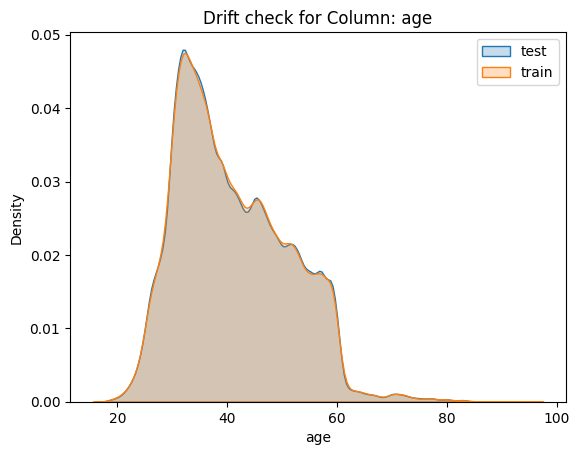

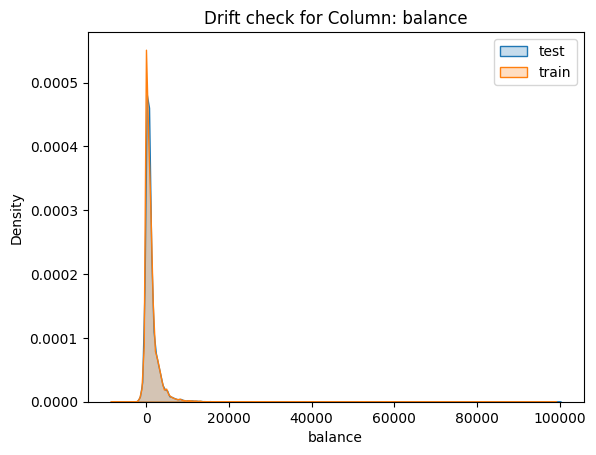

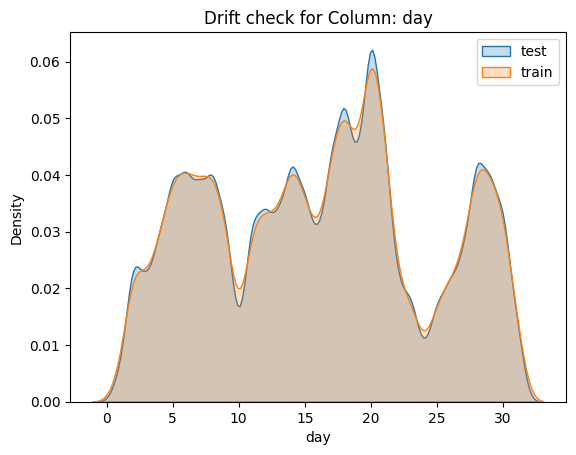

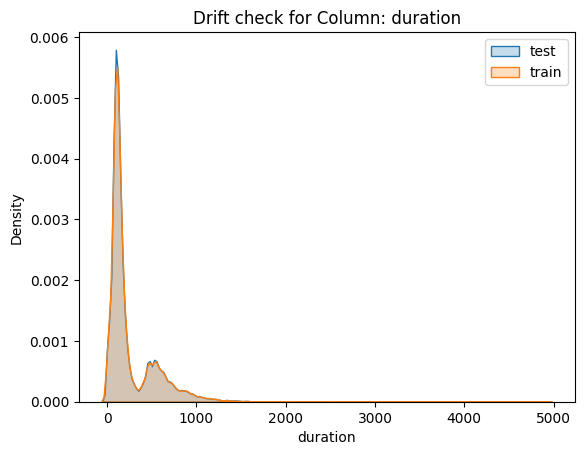

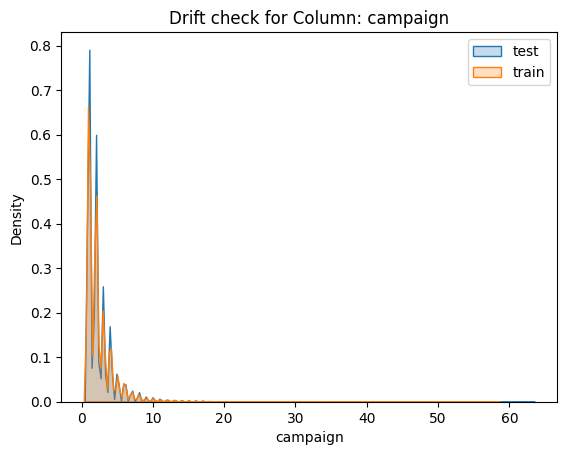

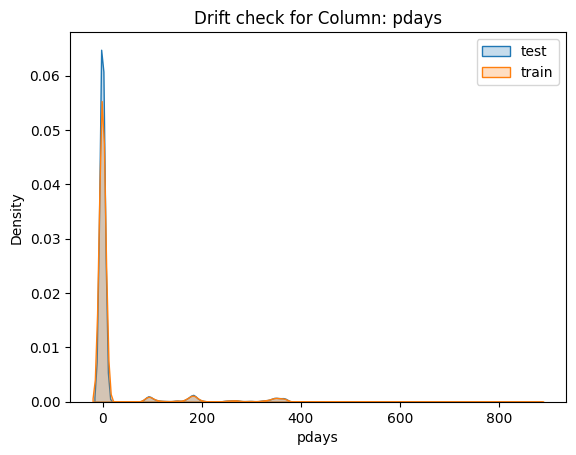

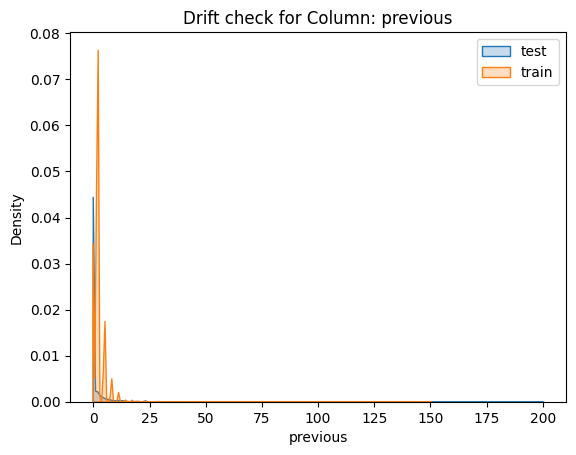

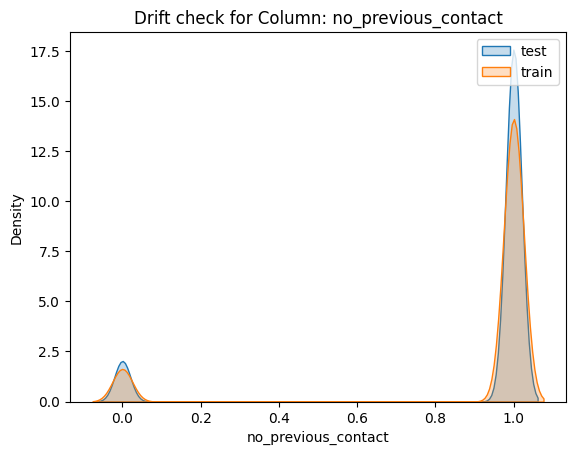

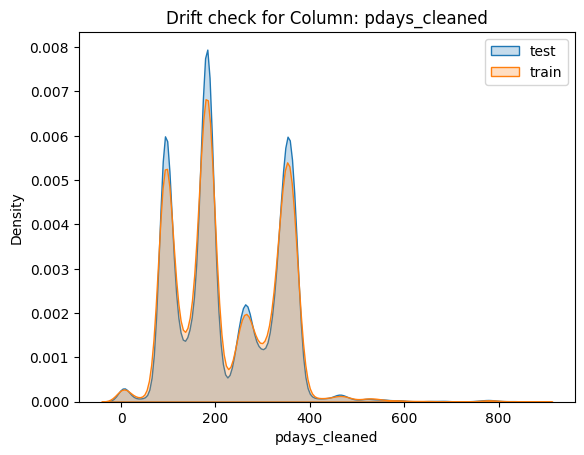

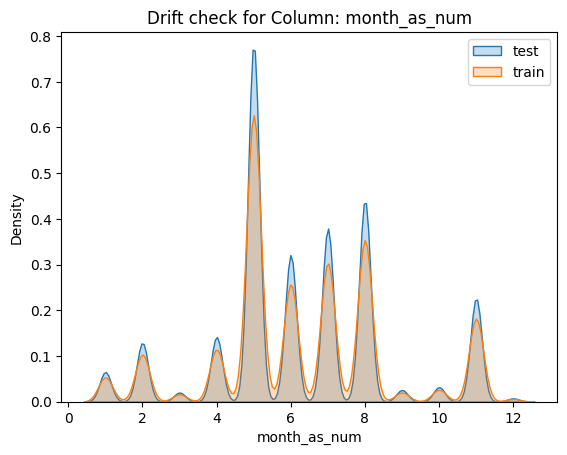

In [133]:
for col in test_df.columns:
    if col != 'id' and test_df[col].dtype in[np.int64,np.float64]:
        sns.kdeplot(train_df[col], label='test', fill=True)
        sns.kdeplot(test_df[col], label='train', fill=True)
        plt.title(f"Drift check for Column: {col}")
        plt.legend()
        plt.show()

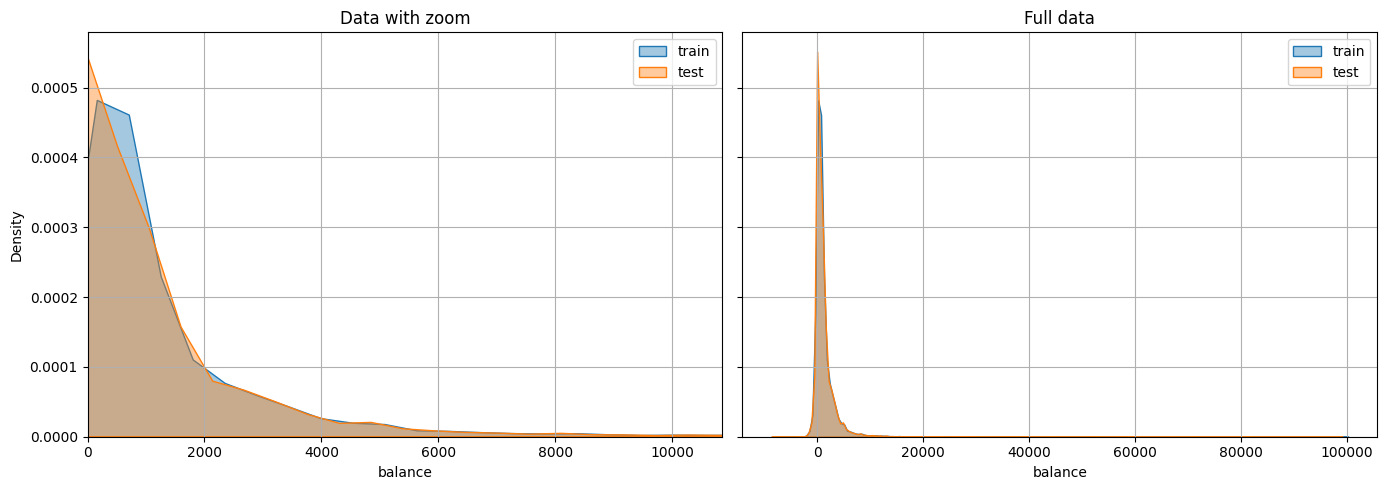

In [134]:
feature ='balance'

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
upper_limit = train_df[feature].quantile(0.99)

# Zoom 
sns.kdeplot(data=train_df, x=feature, ax=axes[0], label='train', fill=True, alpha=0.4)
sns.kdeplot(data=test_df, x=feature, ax=axes[0], label='test', fill=True, alpha=0.4)
axes[0].set_xlim(-1, upper_limit)
axes[0].set_title('Data with zoom')

# Full data
sns.kdeplot(data=train_df, x=feature, ax=axes[1], label='train', fill=True, alpha=0.4)
sns.kdeplot(data=test_df, x=feature, ax=axes[1], label='test', fill=True, alpha=0.4)
axes[1].set_title('Full data')

for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

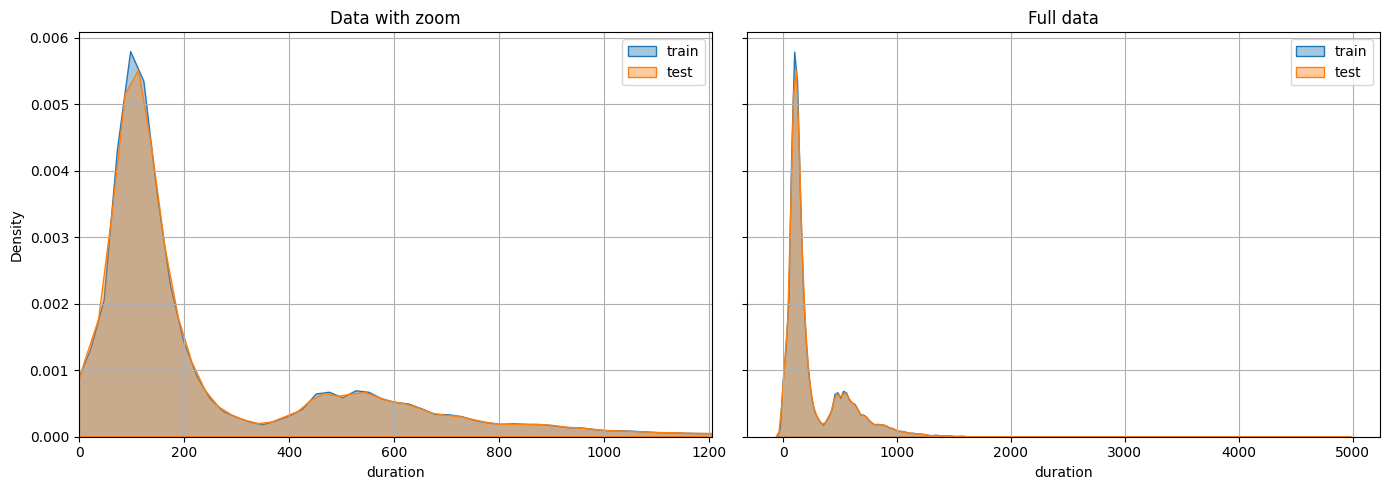

In [135]:
feature ='duration'

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
upper_limit = train_df[feature].quantile(0.99)

# Zoom 
sns.kdeplot(data=train_df, x=feature, ax=axes[0], label='train', fill=True, alpha=0.4)
sns.kdeplot(data=test_df, x=feature, ax=axes[0], label='test', fill=True, alpha=0.4)
axes[0].set_xlim(-1, upper_limit)
axes[0].set_title('Data with zoom')

# Full data
sns.kdeplot(data=train_df, x=feature, ax=axes[1], label='train', fill=True, alpha=0.4)
sns.kdeplot(data=test_df, x=feature, ax=axes[1], label='test', fill=True, alpha=0.4)
axes[1].set_title('Full data')

for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

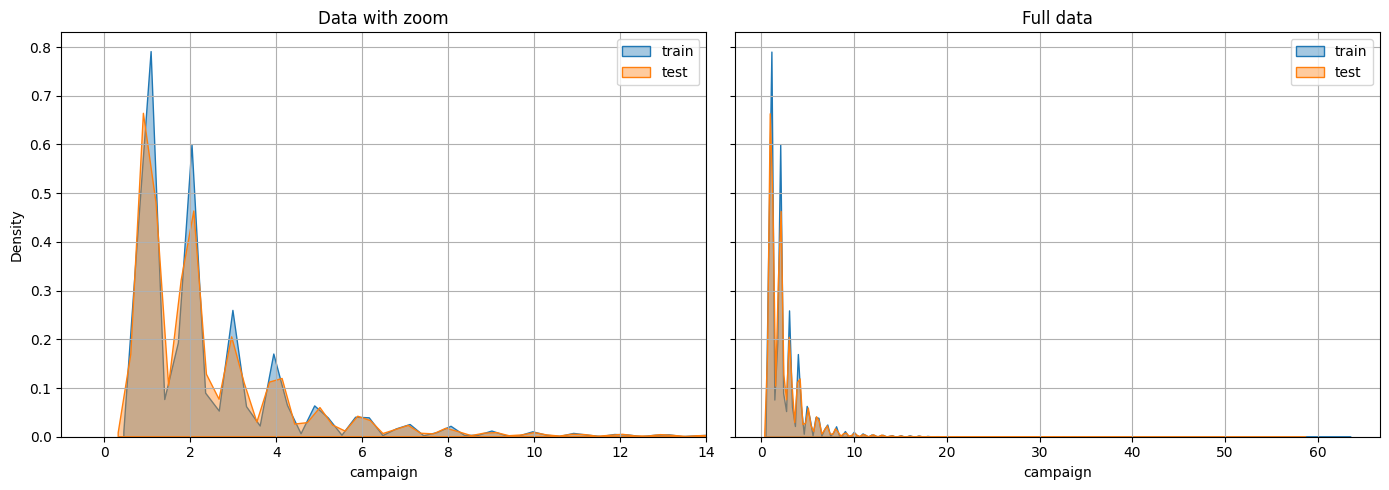

In [136]:
feature ='campaign'

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
upper_limit = train_df[feature].quantile(0.99)

# Zoom 
sns.kdeplot(data=train_df, x=feature, ax=axes[0], label='train', fill=True, alpha=0.4)
sns.kdeplot(data=test_df, x=feature, ax=axes[0], label='test', fill=True, alpha=0.4)
axes[0].set_xlim(-1, upper_limit)
axes[0].set_title('Data with zoom')

# Full data
sns.kdeplot(data=train_df, x=feature, ax=axes[1], label='train', fill=True, alpha=0.4)
sns.kdeplot(data=test_df, x=feature, ax=axes[1], label='test', fill=True, alpha=0.4)
axes[1].set_title('Full data')

for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

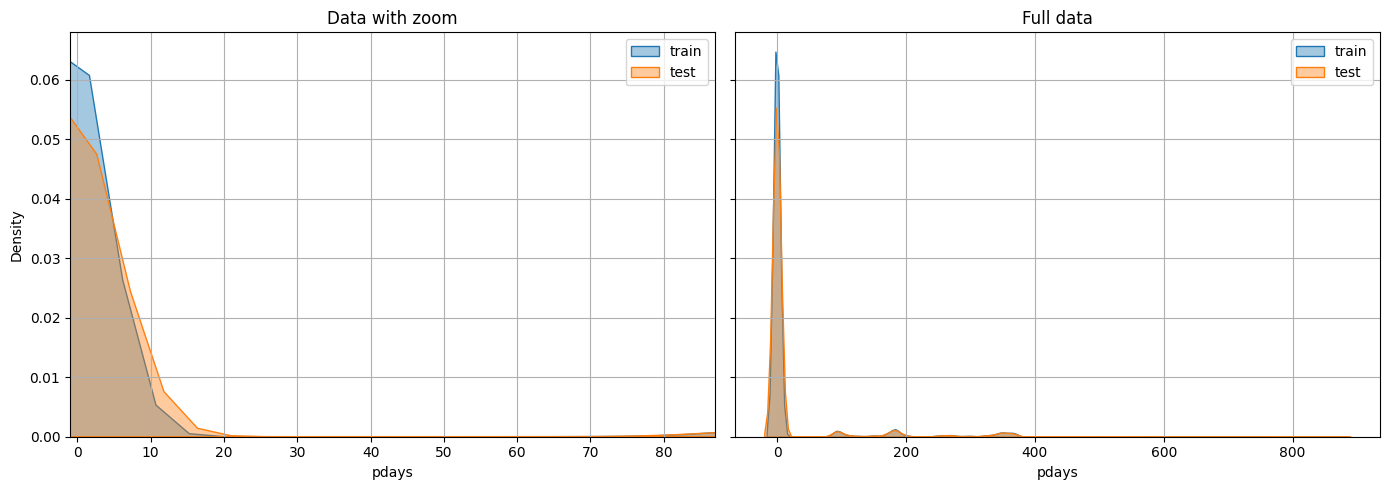

In [137]:
feature ='pdays'

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
upper_limit = train_df[feature].quantile(0.9)

# Zoom 
sns.kdeplot(data=train_df, x=feature, ax=axes[0], label='train', fill=True, alpha=0.4)
sns.kdeplot(data=test_df, x=feature, ax=axes[0], label='test', fill=True, alpha=0.4)
axes[0].set_xlim(-1, upper_limit)
axes[0].set_title('Data with zoom')

# Full data
sns.kdeplot(data=train_df, x=feature, ax=axes[1], label='train', fill=True, alpha=0.4)
sns.kdeplot(data=test_df, x=feature, ax=axes[1], label='test', fill=True, alpha=0.4)
axes[1].set_title('Full data')

for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

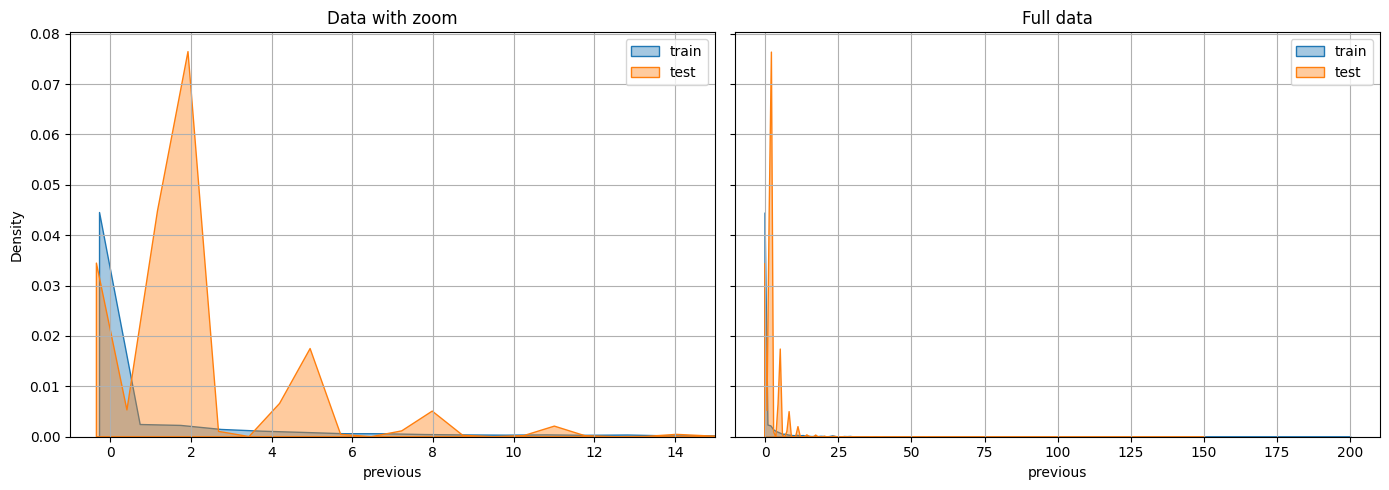

In [138]:
feature ='previous'

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
upper_limit = train_df[feature].quantile(0.999)

# Zoom 
sns.kdeplot(data=train_df, x=feature, ax=axes[0], label='train', fill=True, alpha=0.4)
sns.kdeplot(data=test_df, x=feature, ax=axes[0], label='test', fill=True, alpha=0.4)
axes[0].set_xlim(-1, upper_limit)
axes[0].set_title('Data with zoom')

# Full data
sns.kdeplot(data=train_df, x=feature, ax=axes[1], label='train', fill=True, alpha=0.4)
sns.kdeplot(data=test_df, x=feature, ax=axes[1], label='test', fill=True, alpha=0.4)
axes[1].set_title('Full data')

for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

### Categorical columns drift check

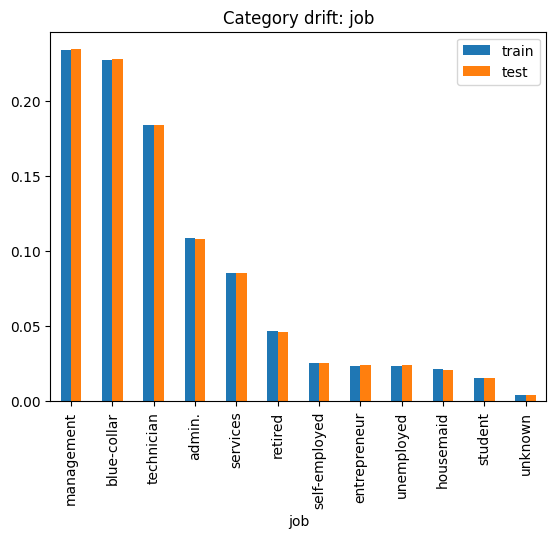

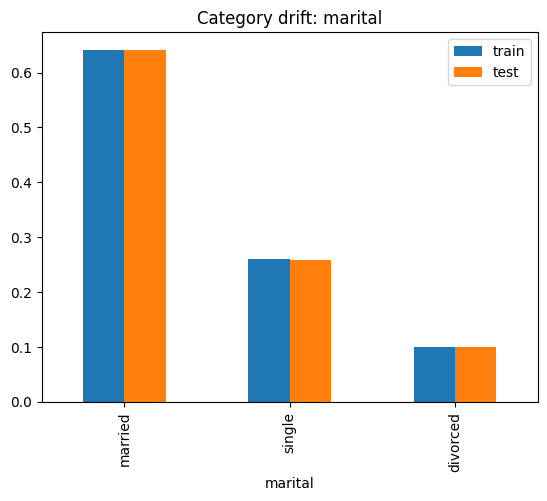

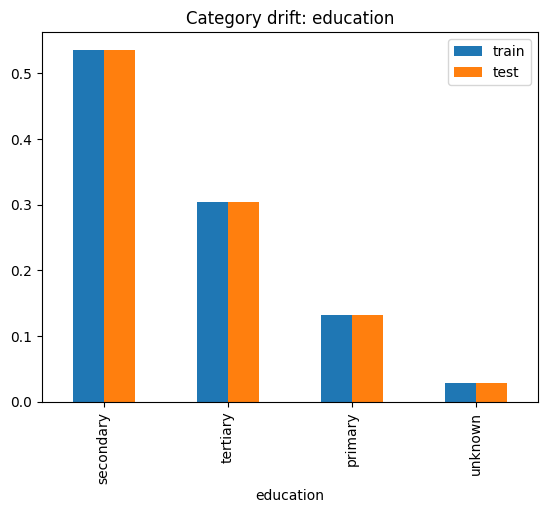

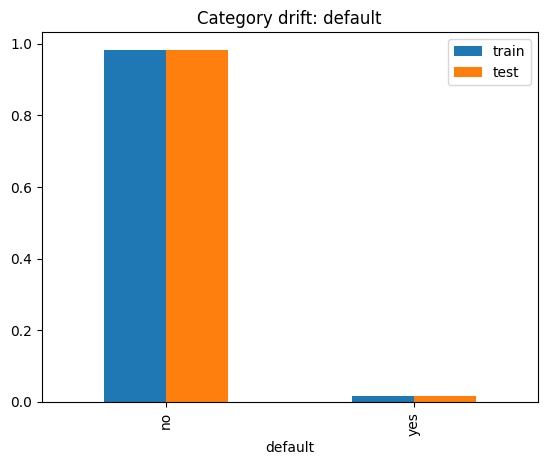

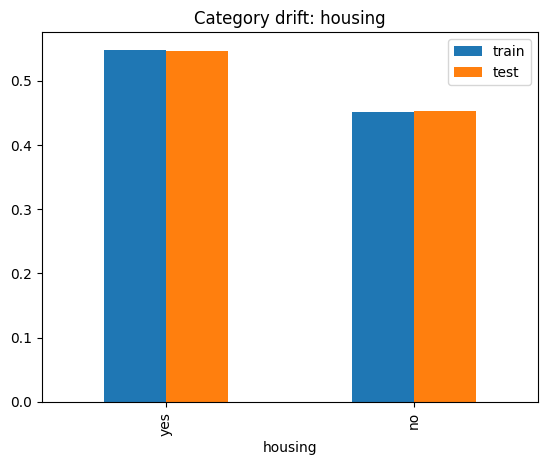

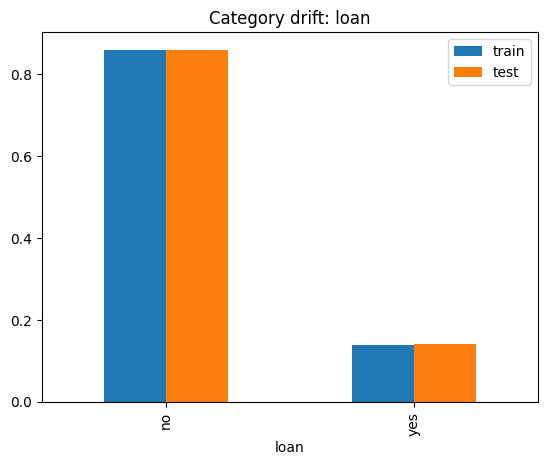

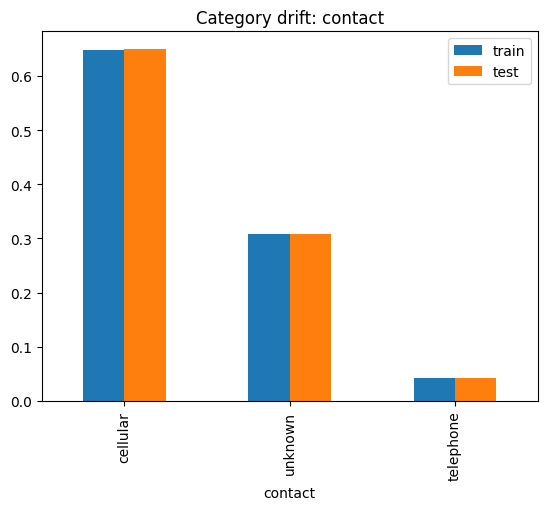

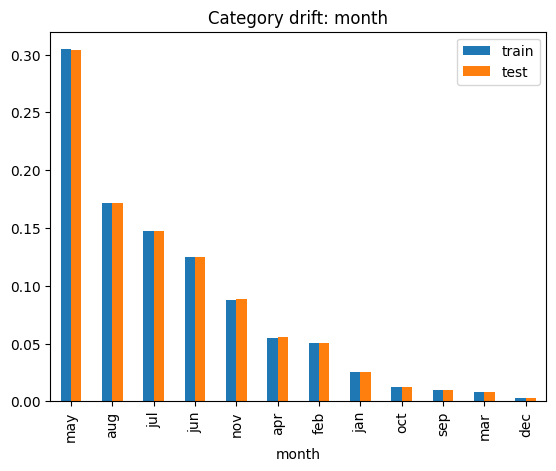

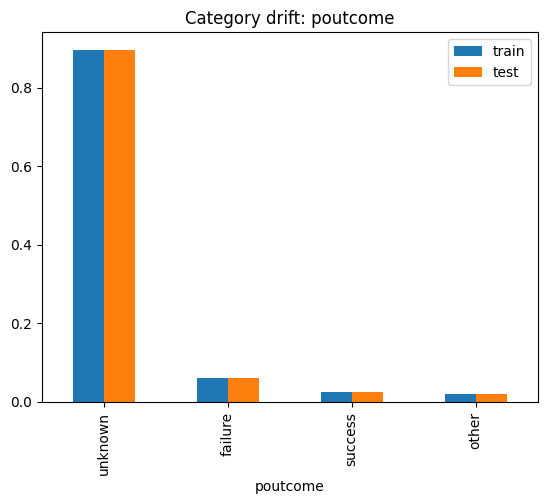

In [139]:
def plot_category_drift(feature):
    pd.concat([
        train_df[feature].value_counts(normalize=True).rename("train"),
        test_df[feature].value_counts(normalize=True).rename("test")
    ], axis=1).plot(kind="bar", title=f"Category drift: {feature}")

columns = [ 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact','month', 'poutcome'  ]

for col in columns:
    plot_category_drift(col)

### Key Observations:
- visible drift for column 'previous'
- no clear drift between train and test data for rest of numeric columns
- no clear drift between train and test data for categorical columns

## 4. Correlation check for train and test data

<Axes: >

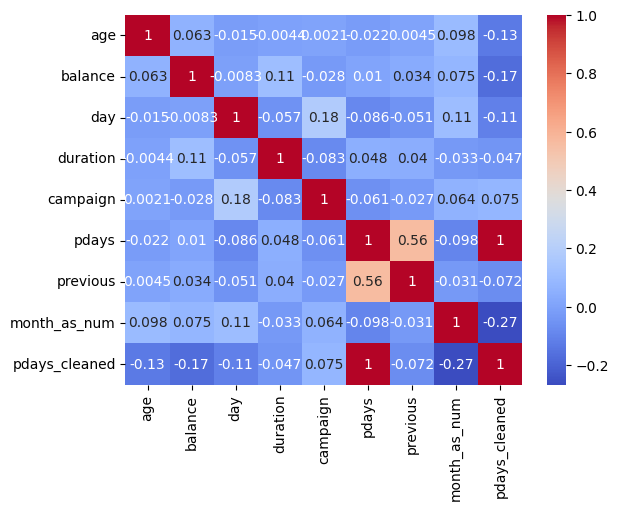

In [140]:
sns.heatmap(train_df[['age', 'balance','day', 'duration','campaign', 'pdays','previous', 'month_as_num', 'pdays_cleaned']].corr(),
            annot = True, cmap='coolwarm')

<Axes: >

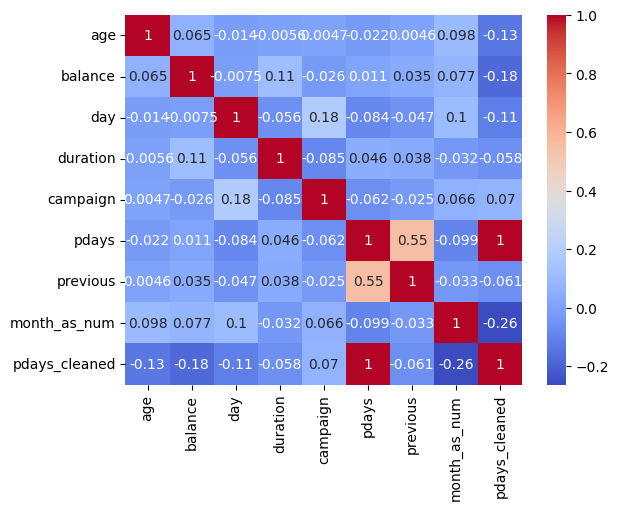

In [141]:
sns.heatmap(test_df[['age', 'balance','day', 'duration','campaign', 'pdays','previous','month_as_num', 'pdays_cleaned']].corr(), 
            annot = True, cmap='coolwarm')

### Key Observations:
- Only pdays and previous columns show strong correlation
- possible weak negative correlation between new columns - month_as_num and pdays_cleaned

## 5. Check of 'y' in each column for train data

### Category columns

y
0    87.93
1    12.07
Name: proportion, dtype: float64

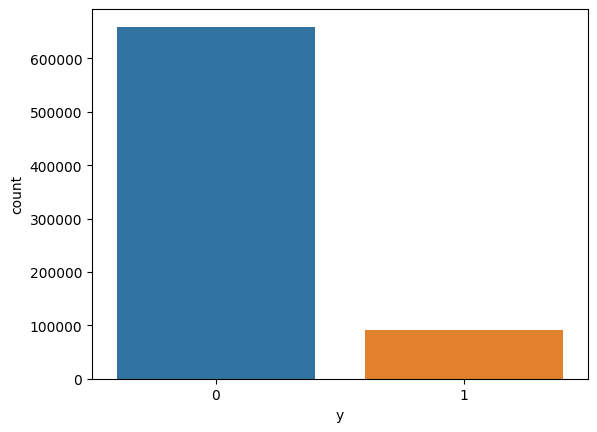

In [142]:
sns.countplot(data=train_df, x='y')
round(train_df['y'].value_counts(normalize=True)*100,2)

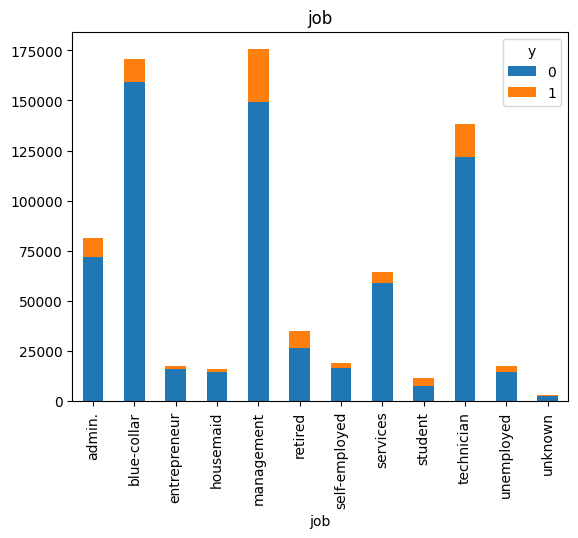

Percentage summary:


y,0,1
job,,
admin.,88.4,11.6
blue-collar,93.3,6.7
entrepreneur,91.9,8.1
housemaid,91.5,8.5
management,85.0,15.0
retired,75.4,24.6
self-employed,87.1,12.9
services,91.7,8.3
student,65.9,34.1


Quantitative summary:


y,0,1
job,,
admin.,72002,9490
blue-collar,159000,11498
entrepreneur,16276,1442
housemaid,14565,1347
management,149141,26400
retired,26521,8664
self-employed,16558,2462
services,58898,5311
student,7757,4010


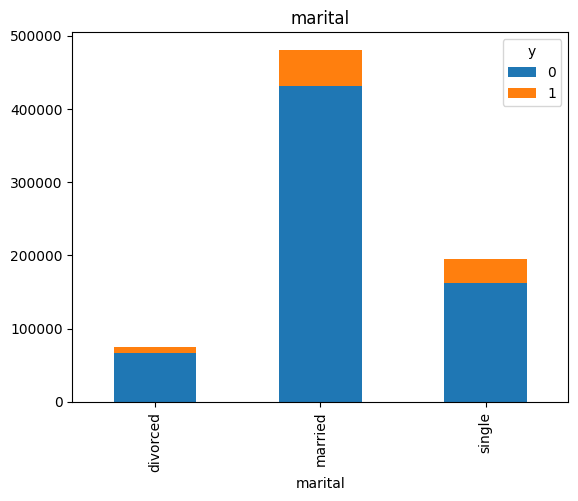

Percentage summary:


y,0,1
marital,,
divorced,88.8,11.2
married,89.8,10.2
single,83.0,17.0


Quantitative summary:


y,0,1
marital,,
divorced,66105,8302
married,431783,48976
single,161624,33210


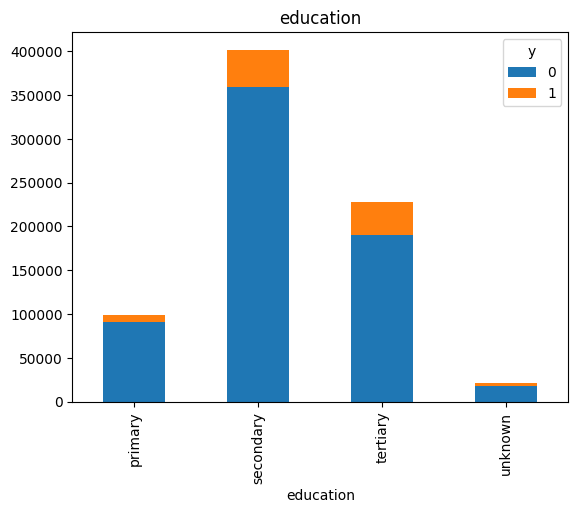

Percentage summary:


y,0,1
education,,
primary,91.7,8.3
secondary,89.5,10.5
tertiary,83.7,16.3
unknown,86.7,13.3


Quantitative summary:


y,0,1
education,,
primary,91241,8269
secondary,359309,42374
tertiary,190504,37004
unknown,18458,2841


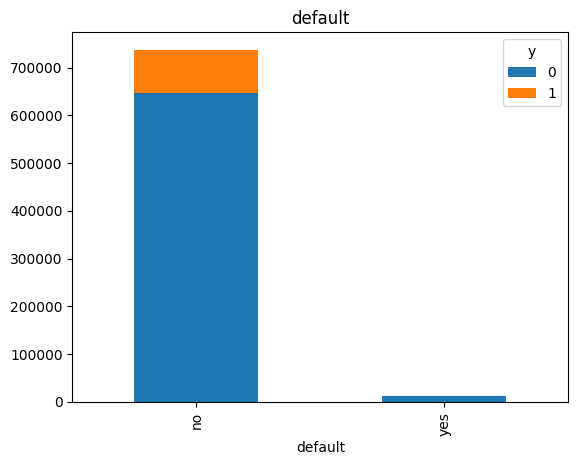

Percentage summary:


y,0,1
default,,
no,87.8,12.2
yes,95.4,4.6


Quantitative summary:


y,0,1
default,,
no,647258,89893
yes,12254,595


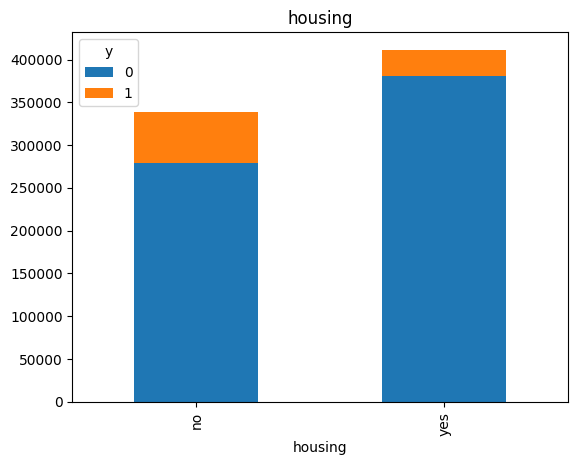

Percentage summary:


y,0,1
housing,,
no,82.4,17.6
yes,92.5,7.5


Quantitative summary:


y,0,1
housing,,
no,279174,59538
yes,380338,30950


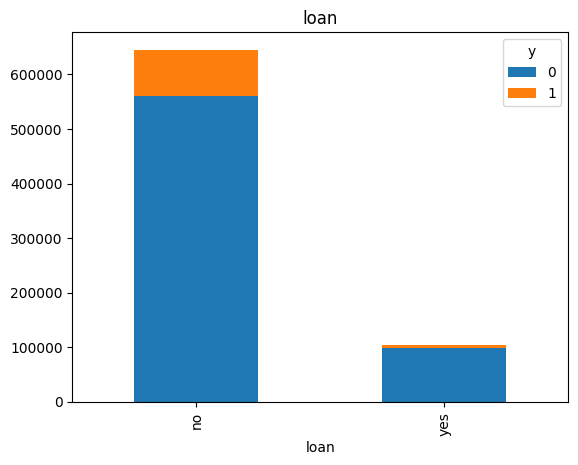

Percentage summary:


y,0,1
loan,,
no,86.9,13.1
yes,94.5,5.5


Quantitative summary:


y,0,1
loan,,
no,560281,84742
yes,99231,5746


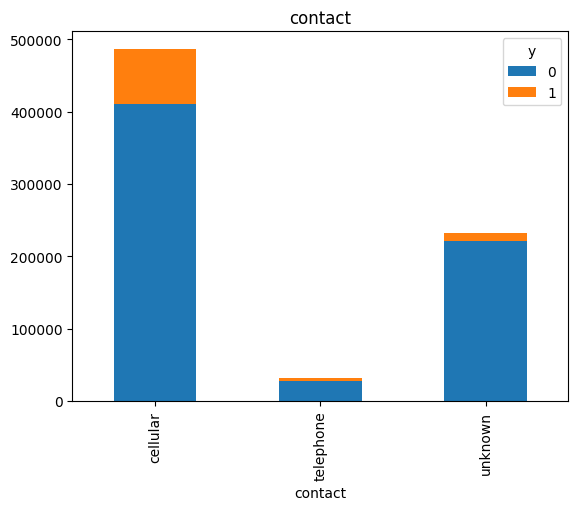

Percentage summary:


y,0,1
contact,,
cellular,84.3,15.7
telephone,86.3,13.7
unknown,95.7,4.3


Quantitative summary:


y,0,1
contact,,
cellular,410455,76200
telephone,27379,4339
unknown,221678,9949


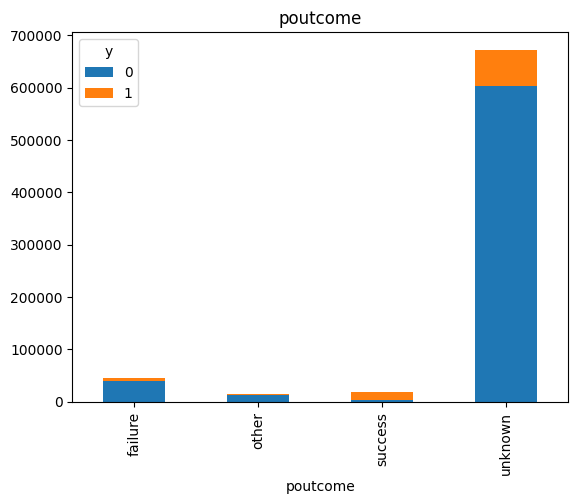

Percentage summary:


y,0,1
poutcome,,
failure,86.7,13.3
other,83.3,16.7
success,23.6,76.4
unknown,89.8,10.2


Quantitative summary:


y,0,1
poutcome,,
failure,39124,5991
other,12284,2460
success,4175,13516
unknown,603929,68521


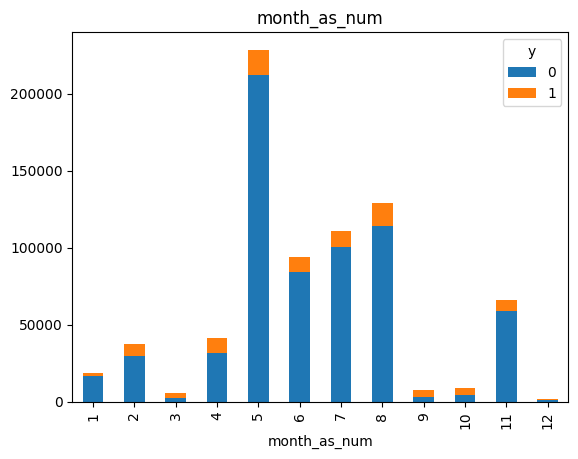

Percentage summary:


y,0,1
month_as_num,,
1,87.6,12.4
2,79.3,20.7
3,42.9,57.1
4,76.4,23.6
5,92.9,7.1
6,89.6,10.4
7,90.9,9.1
8,88.8,11.2
9,46.5,53.5


Quantitative summary:


y,0,1
month_as_num,,
1,16586,2351
2,29833,7778
3,2487,3315
4,31582,9737
5,212113,16298
6,83954,9716
7,100595,10052
8,114406,14453
9,3447,3962


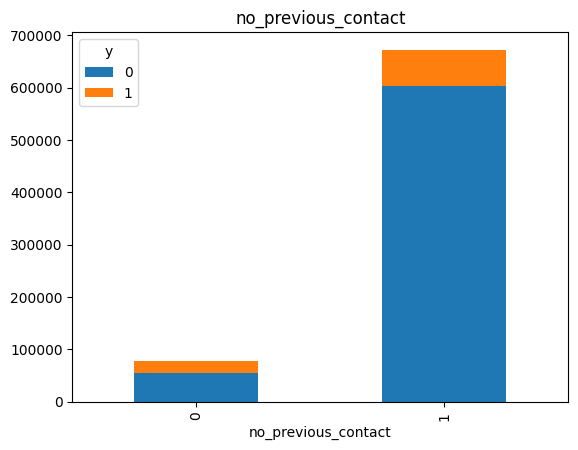

Percentage summary:


y,0,1
no_previous_contact,,
0,71.7,28.3
1,89.8,10.2


Quantitative summary:


y,0,1
no_previous_contact,,
0,55601,21965
1,603911,68523


In [143]:
columns = [ 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',  'poutcome', 
            'month_as_num', 'no_previous_contact']
for col in columns:
    train_df.groupby([col,'y']).size().unstack().plot(kind='bar', stacked=True, title=col)
    plt.show()
    print('Percentage summary:')
    display((pd.crosstab(train_df[col], train_df["y"], normalize='index') * 100).round(1))
    print('Quantitative summary:')
    display((pd.crosstab(train_df[col], train_df["y"])))

### Key Observations:
- We have 2 gropus in label column with split 88% 12% - strong unbalance of classes
- Each categorical column show caategories with different ratio of 0 / 1 labels and have potential to be used in classification


### Numerical columns

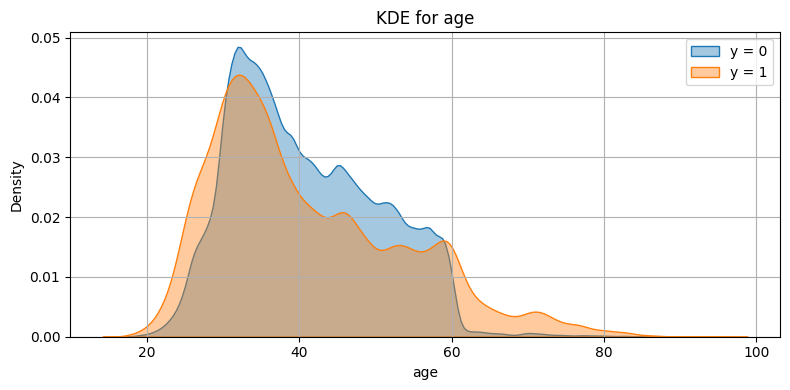

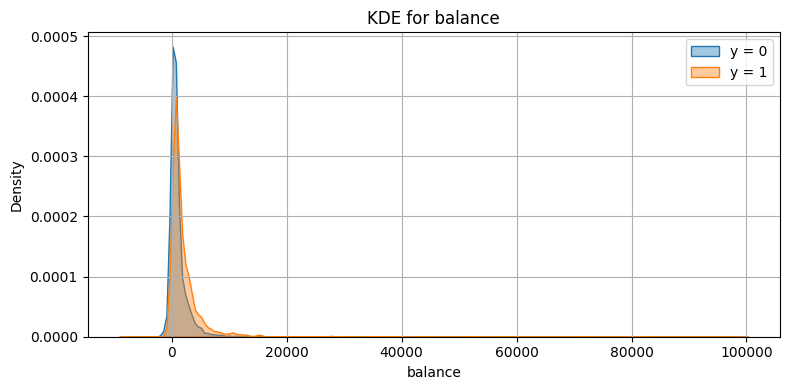

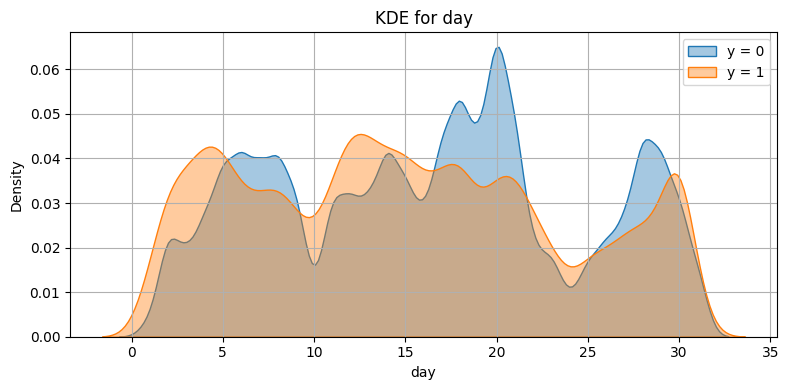

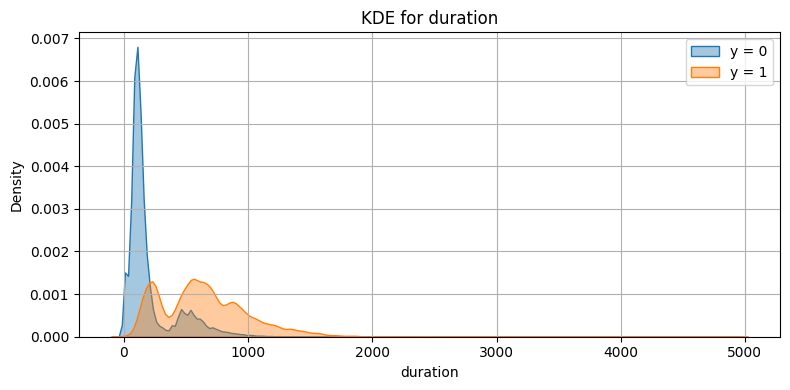

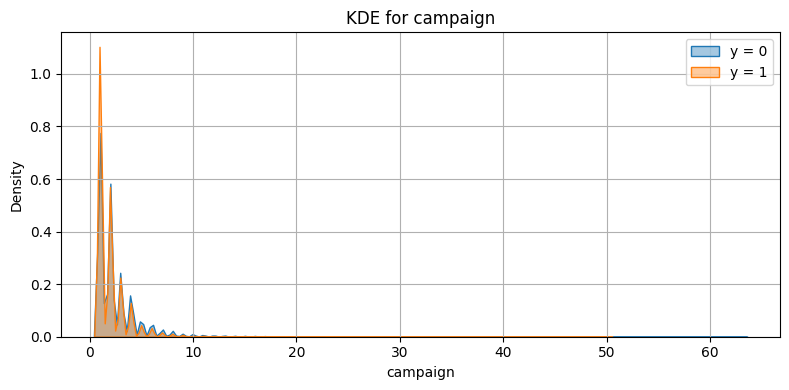

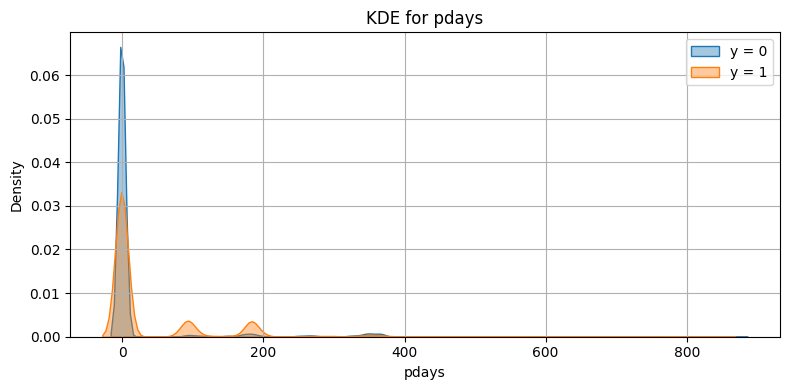

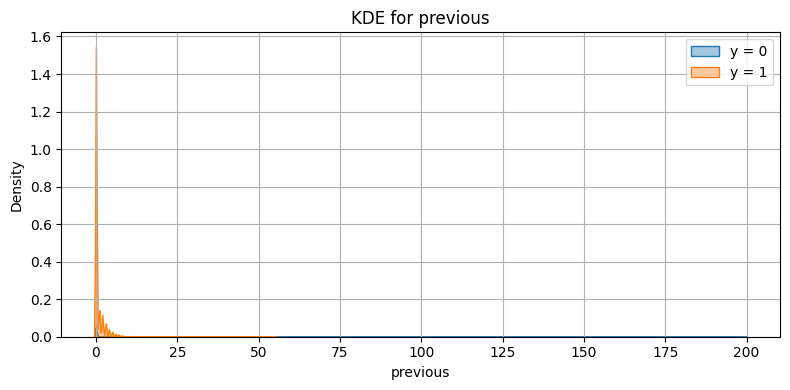

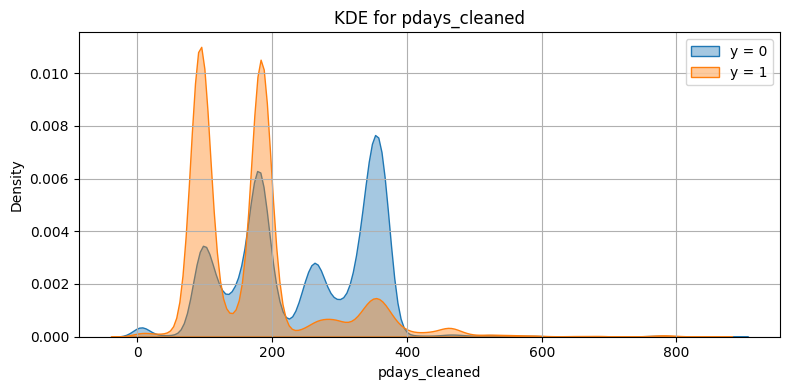

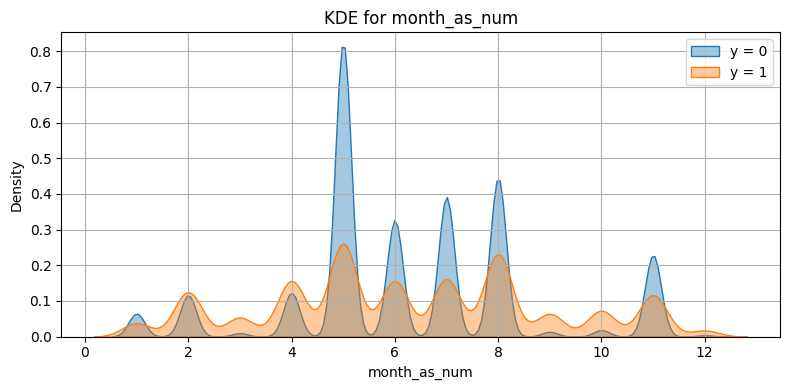

In [144]:
columns = [ 'age','balance', 'day', 'duration', 'campaign', 'pdays', 'previous',  'pdays_cleaned', 'month_as_num']

for feature in columns:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=train_df[train_df['y'] == 0], x=feature, label='y = 0', fill=True, alpha=0.4)
    sns.kdeplot(data=train_df[train_df['y'] == 1], x=feature, label='y = 1', fill=True, alpha=0.4)
    plt.title(f'KDE for {feature}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Key Observations:
- Most of columns show differences in density for labels 0 an 1 and have good potential to be used for classification - age, day, duration, pdays_cleaned, month_as_num
- month column seems to not show cyclical behaviour so it can be probably used as categorical column
- day seems to have no cyclical behaviour so it can be also consider as categorical however 31 categories can be quite large number - to be checked
- new column pdays_cleaned show differences between 0 and 1 but it consider about 11% of data, rest of them is -1
- some plots are not so godd visible so they can be analysed in more details like previous

### Additional plots for more details

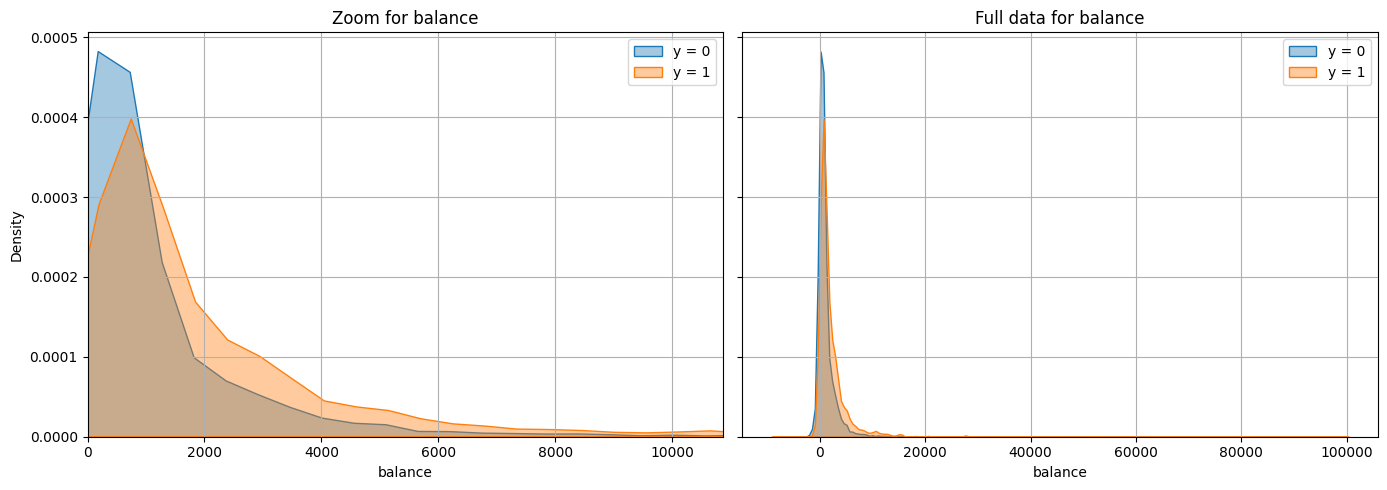

In [145]:
feature ='balance'

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
upper_limit = train_df[feature].quantile(0.99)

# Zoom
sns.kdeplot(data=train_df[train_df['y'] == 0], x=feature, ax=axes[0], label='y = 0', fill=True, alpha=0.4)
sns.kdeplot(data=train_df[train_df['y'] == 1], x=feature, ax=axes[0], label='y = 1', fill=True, alpha=0.4)
axes[0].set_xlim(0, upper_limit)
axes[0].set_title(f'Zoom for {feature}')

# Full
sns.kdeplot(data=train_df[train_df['y'] == 0], x=feature, ax=axes[1], label='y = 0', fill=True, alpha=0.4)
sns.kdeplot(data=train_df[train_df['y'] == 1], x=feature, ax=axes[1], label='y = 1', fill=True, alpha=0.4)
axes[1].set_title(f'Full data for {feature}')

for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

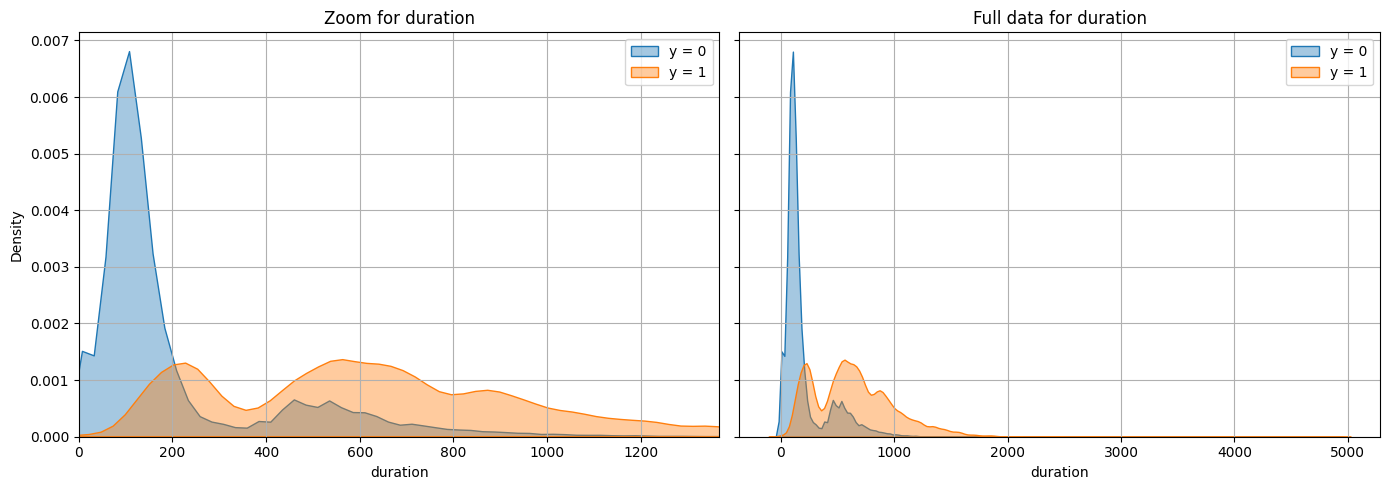

In [146]:
feature ='duration'

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
upper_limit = train_df[feature].quantile(0.995)

# Zoom
sns.kdeplot(data=train_df[train_df['y'] == 0], x=feature, ax=axes[0], label='y = 0', fill=True, alpha=0.4)
sns.kdeplot(data=train_df[train_df['y'] == 1], x=feature, ax=axes[0], label='y = 1', fill=True, alpha=0.4)
axes[0].set_xlim(0, upper_limit)
axes[0].set_title(f'Zoom for {feature}')

# Full
sns.kdeplot(data=train_df[train_df['y'] == 0], x=feature, ax=axes[1], label='y = 0', fill=True, alpha=0.4)
sns.kdeplot(data=train_df[train_df['y'] == 1], x=feature, ax=axes[1], label='y = 1', fill=True, alpha=0.4)
axes[1].set_title(f'Full data for {feature}')

for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

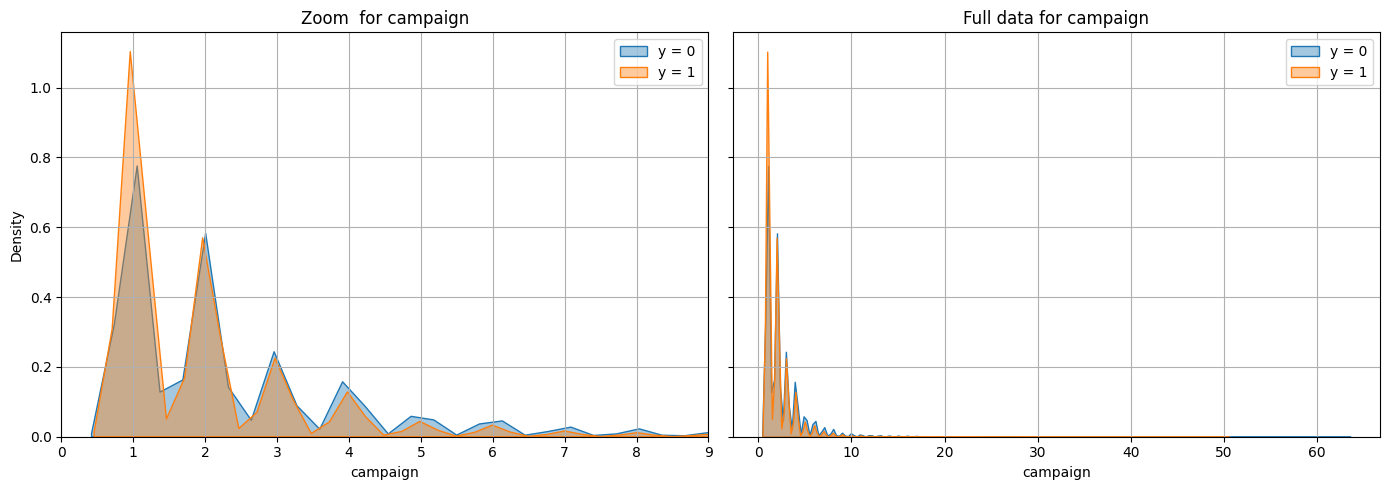

In [147]:
feature ='campaign'

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
upper_limit = train_df[feature].quantile(0.97)

# Zoom
sns.kdeplot(data=train_df[train_df['y'] == 0], x=feature, ax=axes[0], label='y = 0', fill=True, alpha=0.4)
sns.kdeplot(data=train_df[train_df['y'] == 1], x=feature, ax=axes[0], label='y = 1', fill=True, alpha=0.4)
axes[0].set_xlim(0, upper_limit)
axes[0].set_title(f'Zoom  for {feature}')

# Full
sns.kdeplot(data=train_df[train_df['y'] == 0], x=feature, ax=axes[1], label='y = 0', fill=True, alpha=0.4)
sns.kdeplot(data=train_df[train_df['y'] == 1], x=feature, ax=axes[1], label='y = 1', fill=True, alpha=0.4)
axes[1].set_title(f'Full data for {feature}')

for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

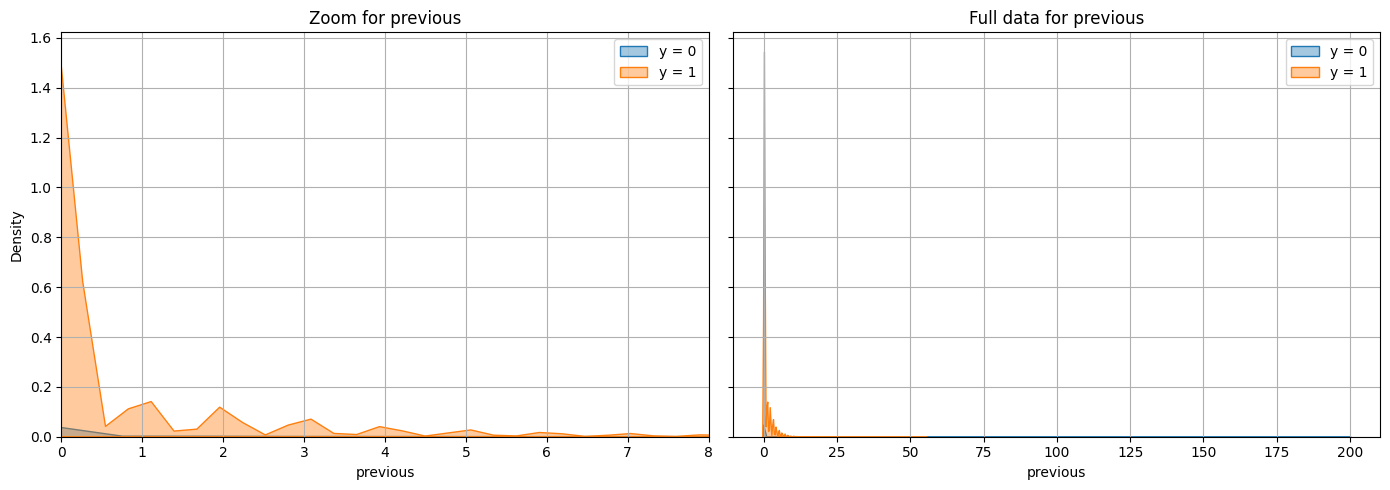

In [148]:
feature ='previous'

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
upper_limit = train_df[feature].quantile(0.995)

# Zoom
sns.kdeplot(data=train_df[train_df['y'] == 0], x=feature, ax=axes[0], label='y = 0', fill=True, alpha=0.4)
sns.kdeplot(data=train_df[train_df['y'] == 1], x=feature, ax=axes[0], label='y = 1', fill=True, alpha=0.4)
axes[0].set_xlim(0, upper_limit)
axes[0].set_title(f'Zoom for {feature}')

# Full
sns.kdeplot(data=train_df[train_df['y'] == 0], x=feature, ax=axes[1], label='y = 0', fill=True, alpha=0.4)
sns.kdeplot(data=train_df[train_df['y'] == 1], x=feature, ax=axes[1], label='y = 1', fill=True, alpha=0.4)
axes[1].set_title(f'Full data for {feature}')

for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

### Key Observations:
- Balance column show small differences in density - can be verified with feature importance
- duration column show quite good differences in density - it is good potential for classification
- campaign column seems to have no bigger differences -  can be verified with feature importance
- for column previous KDE seems to show much different behaviour and seems to have a very good potential for classification

## 6. Outliners for numerical columns

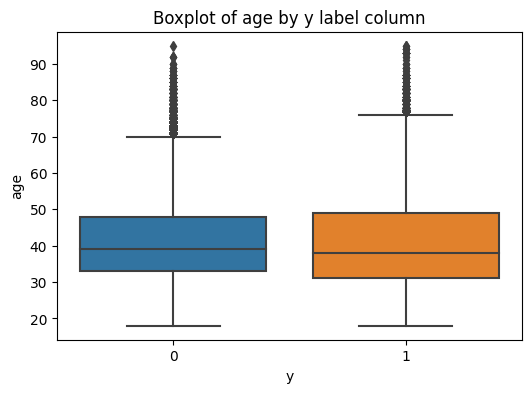

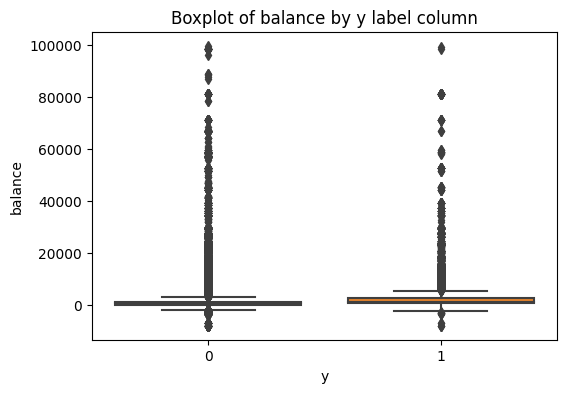

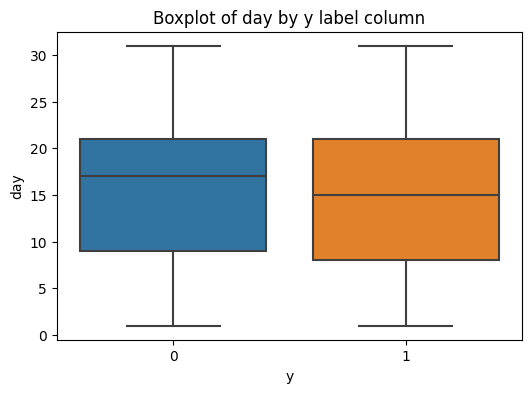

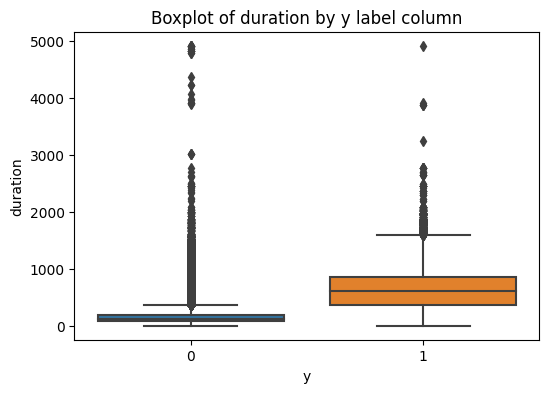

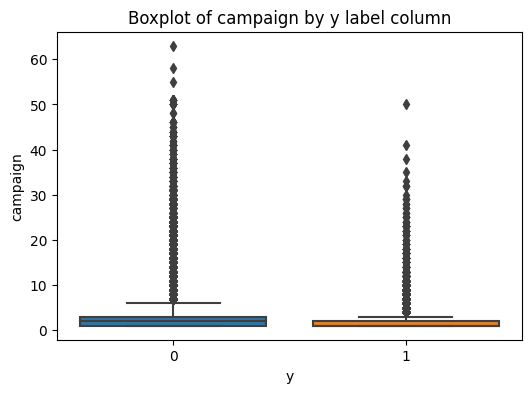

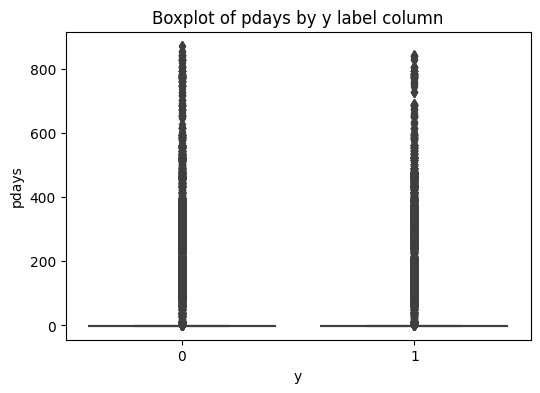

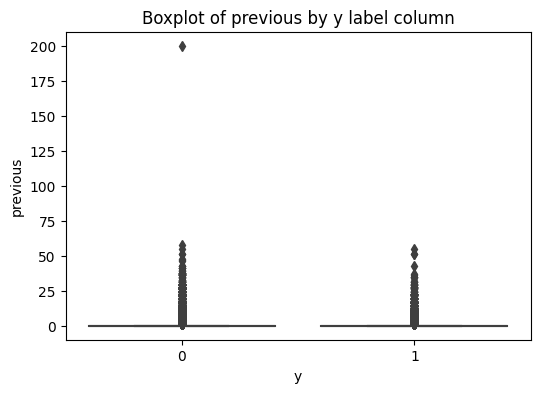

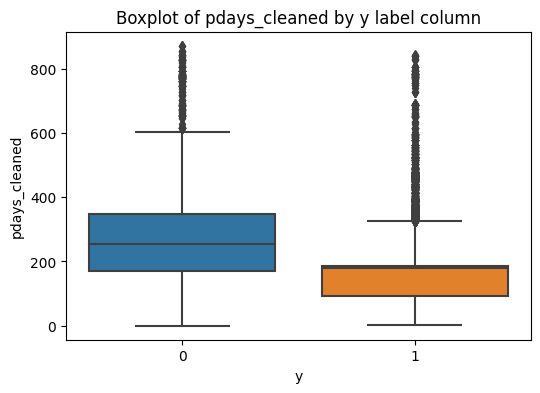

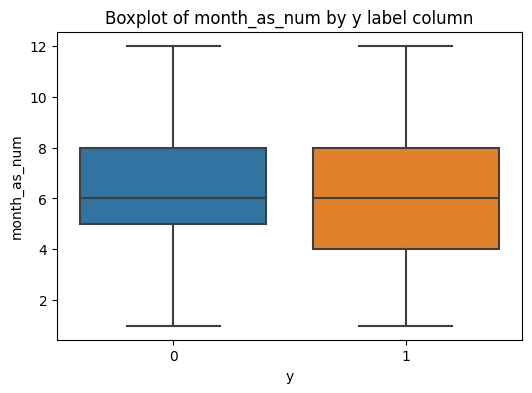

In [149]:
columns = [ 'age','balance', 'day', 'duration', 'campaign', 'pdays', 'previous',  'pdays_cleaned', 'month_as_num']

for col in columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='y', y=col, data=train_df)
    plt.title(f'Boxplot of {col} by y label column')
    plt.show()

### Key Observations:
- age column seems to have  similar character for 0 labels and for 1 labels in term of distribution and outliners
- in balance column there are visible more outliners for label 0, especially for higher values. Box with wiskers seems to be a bit wider and with higher values
- large difference is visible for column duration. More time seems to be related with label 1 and less time with label 0 - can be observed by Q2, Q3, Q4 and median value difference. There is also visible larger group of outliners in category 0 that have high value of contact time in comparision to label 1.
- number of contact in column campaign seems to have slight negative impact when we compare Q3 and Q4 values for label 1 and 0. There is also visible also high number of outliners with large larger number of contact for label 0 comparing to label 1
- pdays column is not visible due to high ammount of -1 values, but after cleanning differences in pdays_cleaned are visible. 

## 7. Ideas for feature engineering

### Column job - grouping by stability of employment


Percentage summary:


y,0,1
job_stability,,
0,87.5,12.5
1,92.6,7.4
2,79.0,21.0


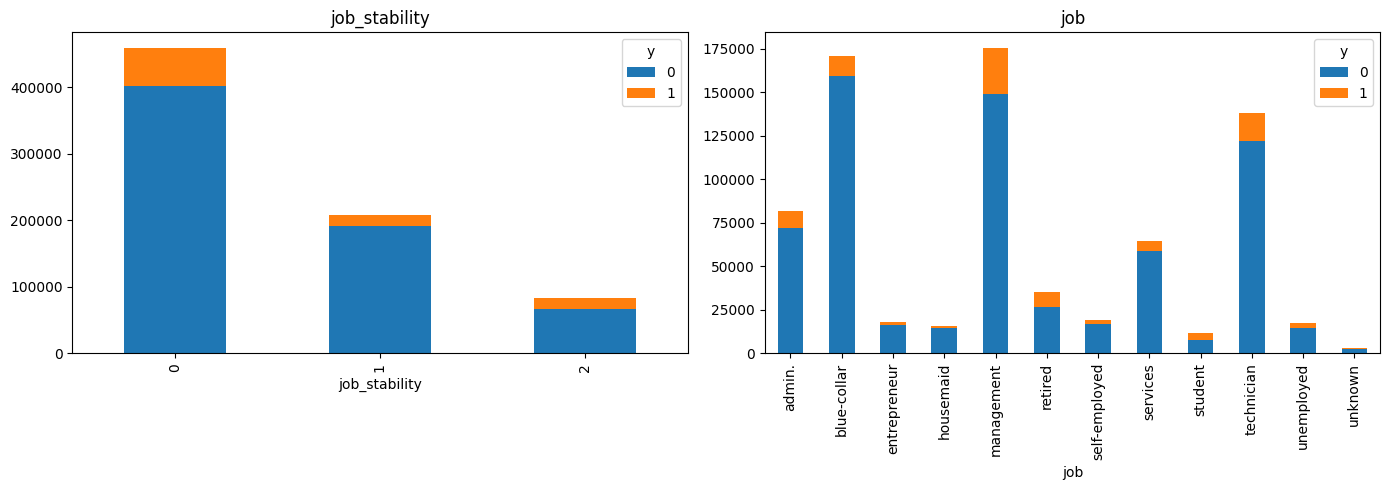

In [150]:
def stability(x):
    if x=='management' or x=='technician' or x=='admin.' or x=='services':
        return 0
    elif x=='blue-collar' or x=='self-employed' or x=='entrepreneur':
        return 1
    else:
        return 2

train_df['job_stability'] = train_df['job'].apply(stability)
print('Percentage summary:')
display((pd.crosstab(train_df['job_stability'], train_df["y"], normalize='index') * 100).round(1))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
train_df.groupby(['job_stability','y']).size().unstack().plot(kind='bar', stacked=True, ax=axes[0], title='job_stability')
train_df.groupby(['job','y']).size().unstack().plot(kind='bar', stacked=True, ax=axes[1], title='job')
plt.tight_layout()
plt.show()

### Key Observations:
- It offers dimension reduction in case overfitting reduction is needed
- original data give more details, groups with different ratio of 0, 1 labels are averaged
- influence can be checked with feature importance as additional column

### Column job - grouping by predictive earnings

Percentage summary:


y,0,1
job_earnings,,
0,85.7,14.3
1,89.0,11.0
2,93.1,6.9
3,76.0,24.0


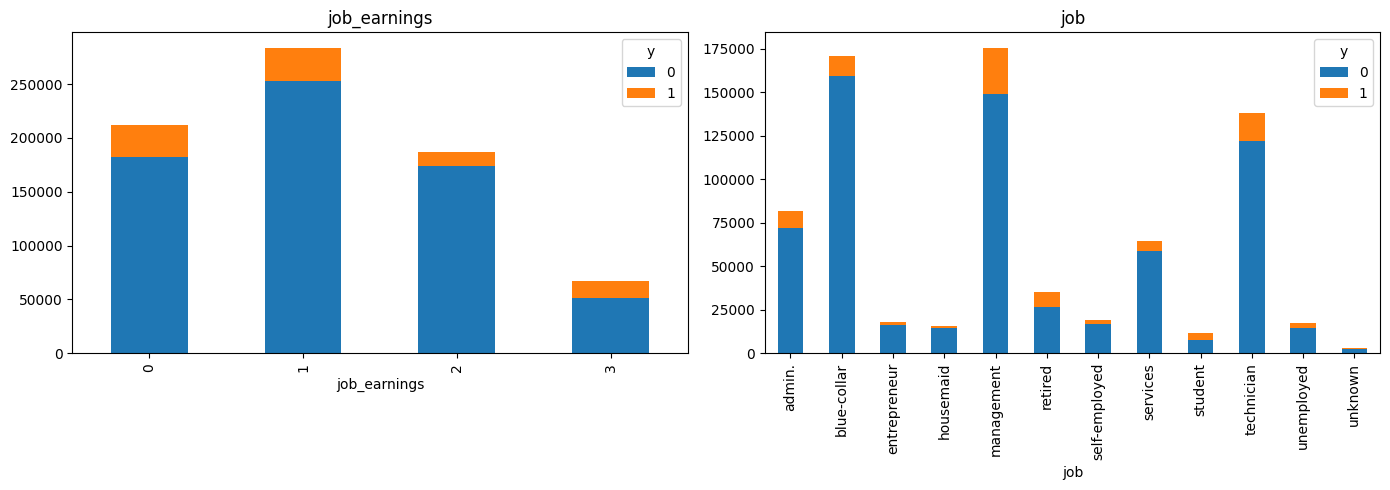

In [151]:
def stability(x):
    #High
    if x=='management' or x=='entrepreneur' or x=='self-employed':
        return 0
    # Middle
    elif x=='technician' or x=='admin.' or x=='services':
        return 1
    # Low
    elif x=='blue-collar' or x=='housemaid':
        return 2
    # No earnings
    else:
        return 3

train_df['job_earnings'] = train_df['job'].apply(stability)
print('Percentage summary:')
display((pd.crosstab(train_df['job_earnings'], train_df["y"], normalize='index') * 100).round(1))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
train_df.groupby(['job_earnings','y']).size().unstack().plot(kind='bar', stacked=True, ax=axes[0], title='job_earnings')
train_df.groupby(['job','y']).size().unstack().plot(kind='bar', stacked=True, ax=axes[1], title='job')
plt.tight_layout()
plt.show()

### Key Observations:
- It offers dimension reduction in case overfitting reduction is needed
- original data give more details, groups with different ratio of 0, 1 labels are averaged
- influence can be checked with feature importance as additional column

### column job - Is person working

Percentage summary:


y,0,1
job_is_working,,
0,76.0,24.0
1,89.1,10.9


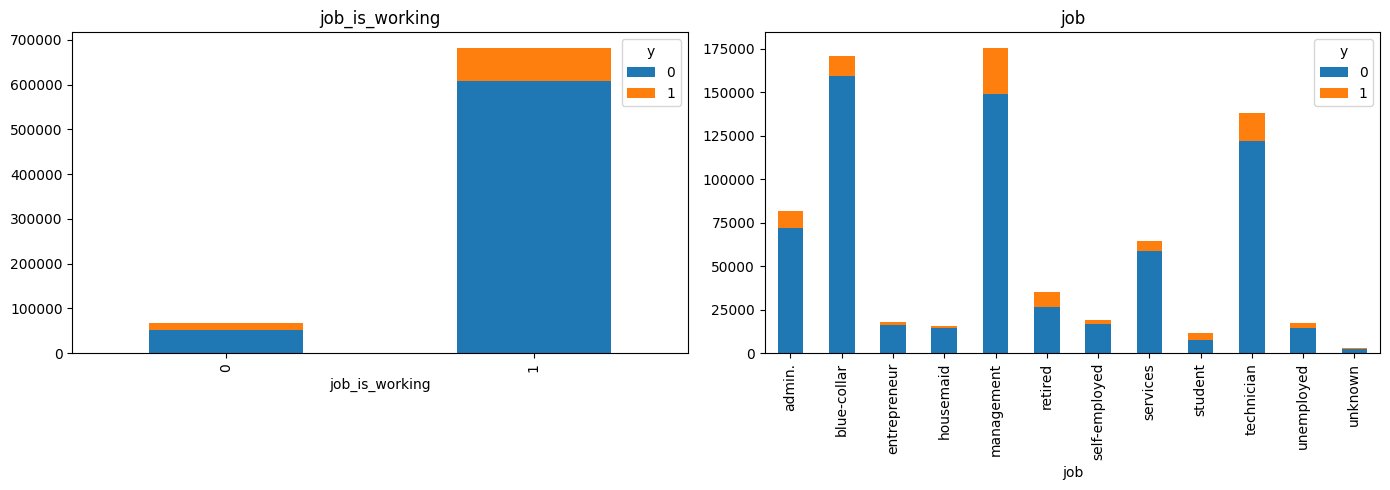

In [152]:
def stability(x):
    #Not working
    if x=='retired' or x=='student' or x=='unemployed' or x=='unknown': 
        return 0
    # working
    else:
        return 1

train_df['job_is_working'] = train_df['job'].apply(stability)
print('Percentage summary:')
display((pd.crosstab(train_df['job_is_working'], train_df["y"], normalize='index') * 100).round(1))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
train_df.groupby(['job_is_working','y']).size().unstack().plot(kind='bar', stacked=True, ax=axes[0], title='job_is_working')
train_df.groupby(['job','y']).size().unstack().plot(kind='bar', stacked=True, ax=axes[1], title='job')
plt.tight_layout()
plt.show()

### Key Observations:
- information about employement can be strong predictor in loan decisions
- influence can be checked with feature importance as additional column

### column poutcome - we can create flag when last campaign was success

prev_success - Percentage summary:


y,0,1
prev_success,,
0,89.5,10.5
1,23.6,76.4


poutcome - Percentage summary:


y,0,1
poutcome,,
failure,86.7,13.3
other,83.3,16.7
success,23.6,76.4
unknown,89.8,10.2


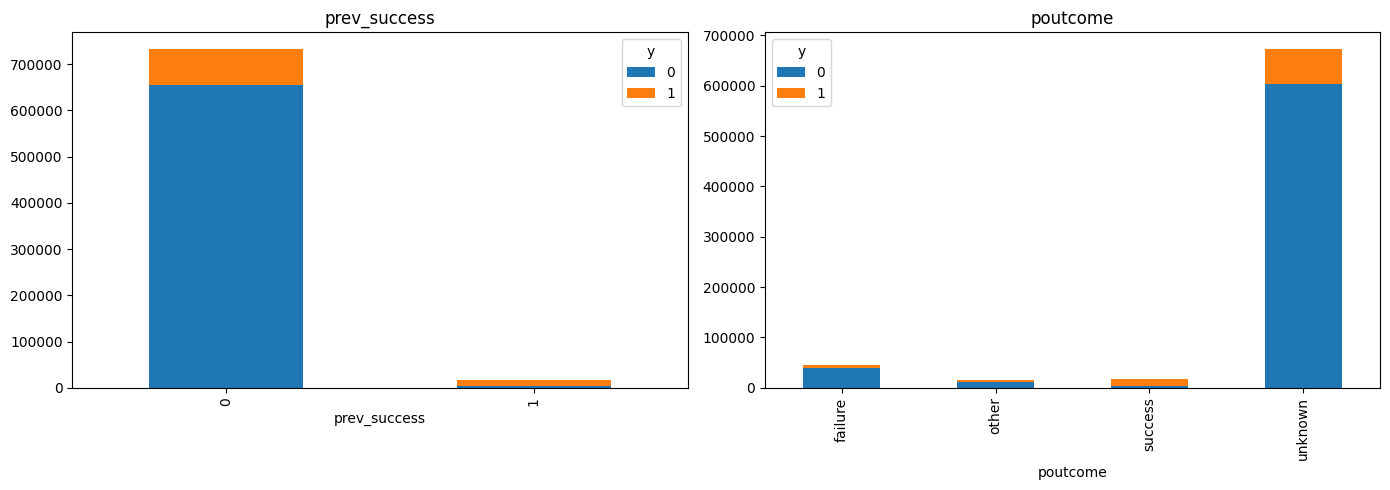

In [153]:
train_df['prev_success']=(train_df['poutcome'] == 'success').astype(int)
print('prev_success - Percentage summary:')
display((pd.crosstab(train_df['prev_success'], train_df["y"], normalize='index') * 100).round(1))
print('poutcome - Percentage summary:')
display((pd.crosstab(train_df['poutcome'], train_df["y"], normalize='index') * 100).round(1))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
train_df.groupby(['prev_success','y']).size().unstack().plot(kind='bar', stacked=True, ax=axes[0], title='prev_success')
train_df.groupby(['poutcome','y']).size().unstack().plot(kind='bar', stacked=True, ax=axes[1], title='poutcome')
plt.tight_layout()
plt.show()


### Key Observations:
- Strong difference is visible between success group nad othe groups can be strong predictor for taking out a loan
- influence can be checked with feature importance as additional column

### Interactions between columns

### Interaction between columns: age * duration

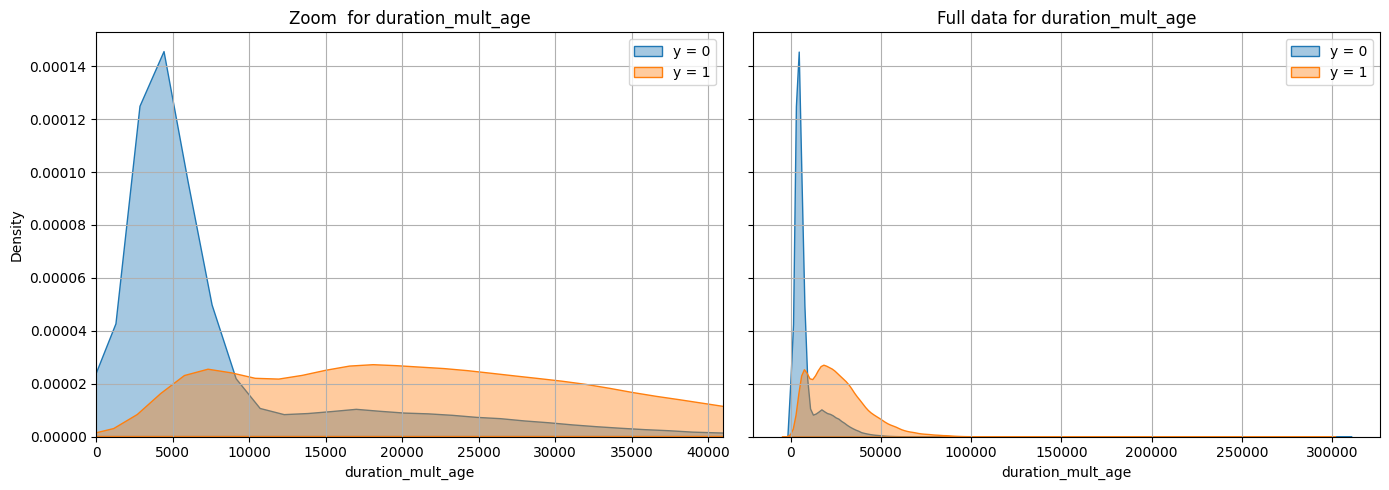

In [154]:
train_df['duration_mult_age'] = train_df['duration'] * train_df['age']

feature ='duration_mult_age'

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
upper_limit = train_df[feature].quantile(0.97)

# Zoom
sns.kdeplot(data=train_df[train_df['y'] == 0], x=feature, ax=axes[0], label='y = 0', fill=True, alpha=0.4)
sns.kdeplot(data=train_df[train_df['y'] == 1], x=feature, ax=axes[0], label='y = 1', fill=True, alpha=0.4)
axes[0].set_xlim(0, upper_limit)
axes[0].set_title(f'Zoom  for {feature}')

# Full
sns.kdeplot(data=train_df[train_df['y'] == 0], x=feature, ax=axes[1], label='y = 0', fill=True, alpha=0.4)
sns.kdeplot(data=train_df[train_df['y'] == 1], x=feature, ax=axes[1], label='y = 1', fill=True, alpha=0.4)
axes[1].set_title(f'Full data for {feature}')

for ax in axes:
    ax.legend()
    ax.grid(True)
    
plt.tight_layout()
plt.show()

### Key Observations:
- Created column shows slighly different shape of density plot then 'duration' only, it is possible that it simplify classification - to be verified

### Interaction between columns: job + education

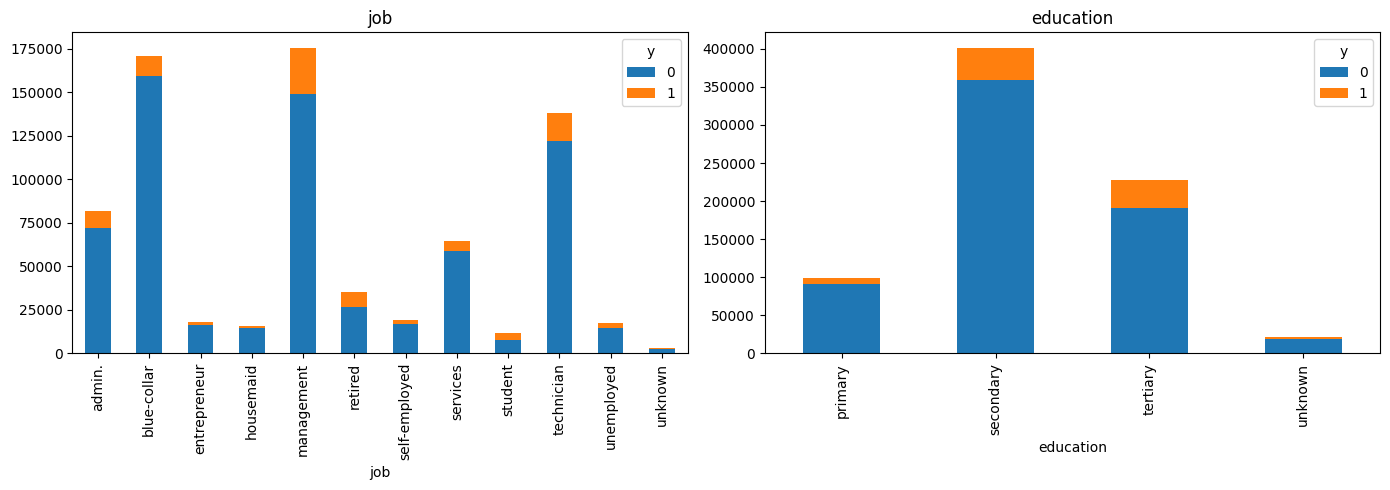

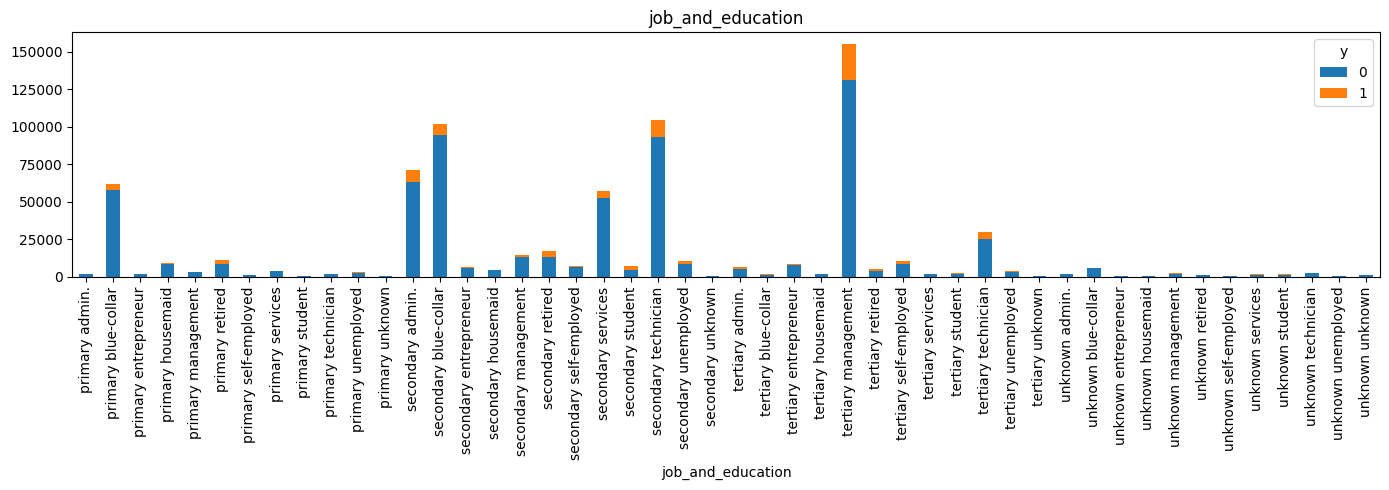

Percentage summary:


y,0,1
job_and_education,,
primary admin.,93.1,6.9
primary blue-collar,94.2,5.8
primary entrepreneur,93.5,6.5
primary housemaid,92.8,7.2
primary management,92.1,7.9
primary retired,76.8,23.2
primary self-employed,94.2,5.8
primary services,94.9,5.1
primary student,67.0,33.0


In [155]:
train_df['job_and_education'] = train_df['education'] + " " + train_df['job']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
train_df.groupby(['job','y']).size().unstack().plot(kind='bar', stacked=True, ax=axes[0], title='job')
train_df.groupby(['education','y']).size().unstack().plot(kind='bar', stacked=True, ax=axes[1], title='education')
plt.tight_layout()
plt.show()

train_df.groupby(['job_and_education','y']).size().unstack().plot(kind='bar', stacked=True, figsize=(14,5), title='job_and_education')
plt.tight_layout()
plt.show()
print('Percentage summary:')
display((pd.crosstab(train_df['job_and_education'], train_df["y"], normalize='index') * 100).round(1))


### Key Observations:
- The combined feature job_and_education massively increases the number of unique categories. This leads to many low-frequency groups, which can become problematic for the model.
- Some combined categories have high counts, while many others are very sparse. These sparse categories can introduce noise, and the model may overfit on these rare cases.
- The distribution of the target variable y across these combined categories shows that some combinations might indeed carry useful signal, which could improve prediction if encoded well.
- Use it with caution

### Interaction between columns: contact + poutcome

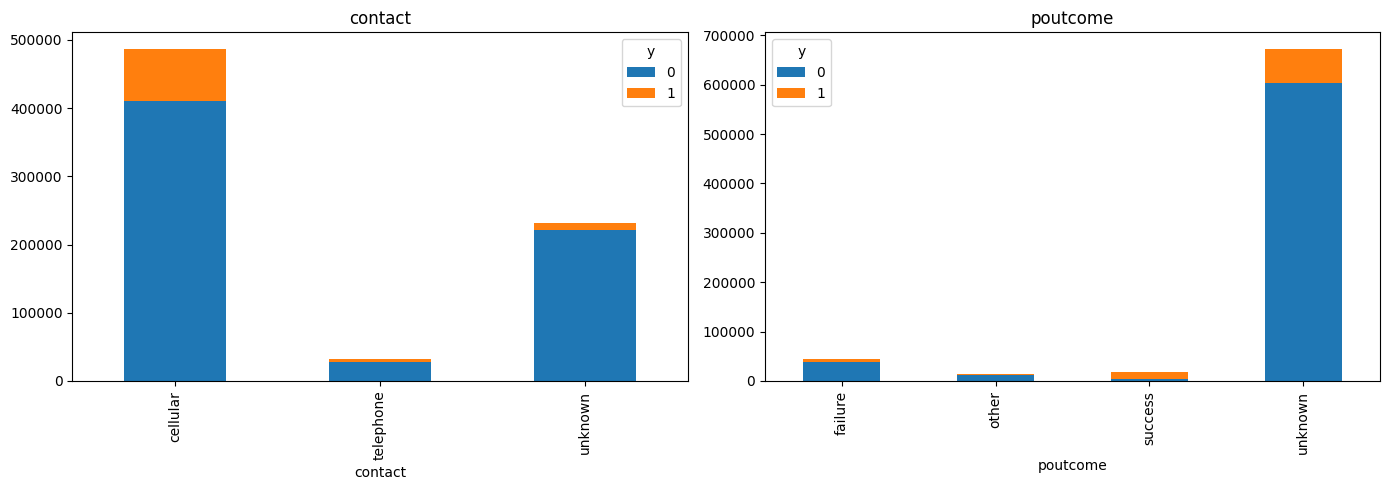

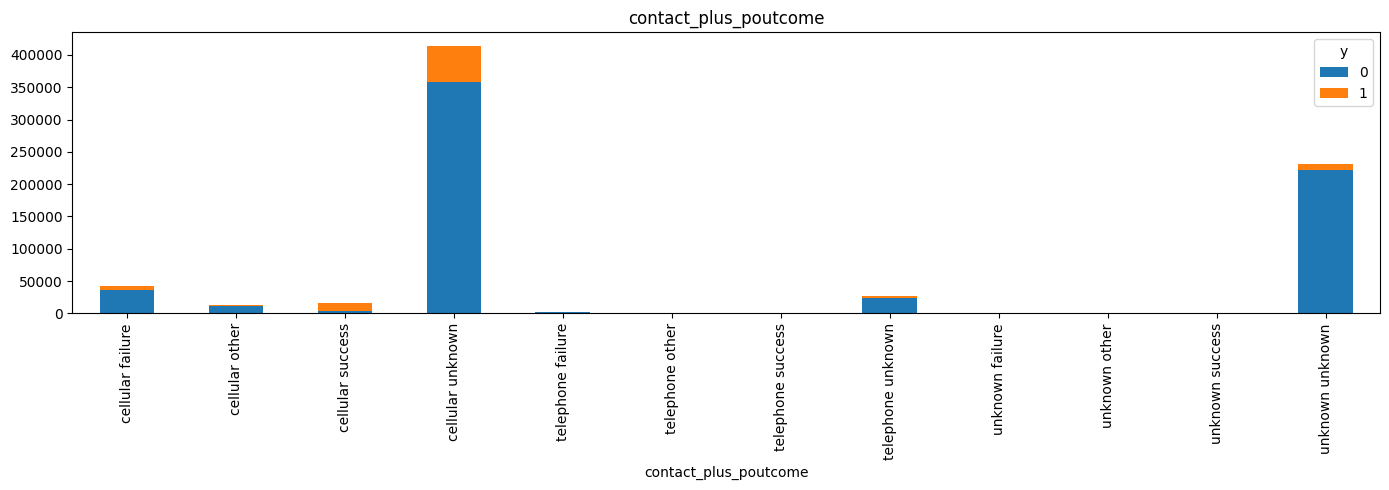

Percentage summary:


y,0,1
contact_plus_poutcome,,
cellular failure,86.6,13.4
cellular other,83.1,16.9
cellular success,23.1,76.9
cellular unknown,86.6,13.4
telephone failure,88.9,11.1
telephone other,86.1,13.9
telephone success,29.1,70.9
telephone unknown,88.3,11.7
unknown failure,83.6,16.4


In [156]:
train_df['contact_plus_poutcome'] = train_df['contact'] + ' ' + train_df['poutcome']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
train_df.groupby(['contact','y']).size().unstack().plot(kind='bar', stacked=True, ax=axes[0], title='contact')
train_df.groupby(['poutcome','y']).size().unstack().plot(kind='bar', stacked=True, ax=axes[1], title='poutcome')
plt.tight_layout()
plt.show()

train_df.groupby(['contact_plus_poutcome','y']).size().unstack().plot(kind='bar', stacked=True, figsize=(14,5), title='contact_plus_poutcome')
plt.tight_layout()
plt.show()
print('Percentage summary:')
display((pd.crosstab(train_df['contact_plus_poutcome'], train_df["y"], normalize='index') * 100).round(1))

### Key Observations:
- The combined feature  increases the number of unique categories, as seen in your bottom plot. This leads to many low-frequency groups, which can become problematic for the model.
- Two combined categories have high counts, while others are sparse or very sparse. These sparse categories can introduce noise, and the model may overfit on these rare cases.
- Use it with caution

### Grouping in columns

### Grouping by age - young / middle / seniors

Percentage summary:


y,0,1
age_group,,
0,79.6,20.4
1,89.7,10.3
2,48.6,51.4


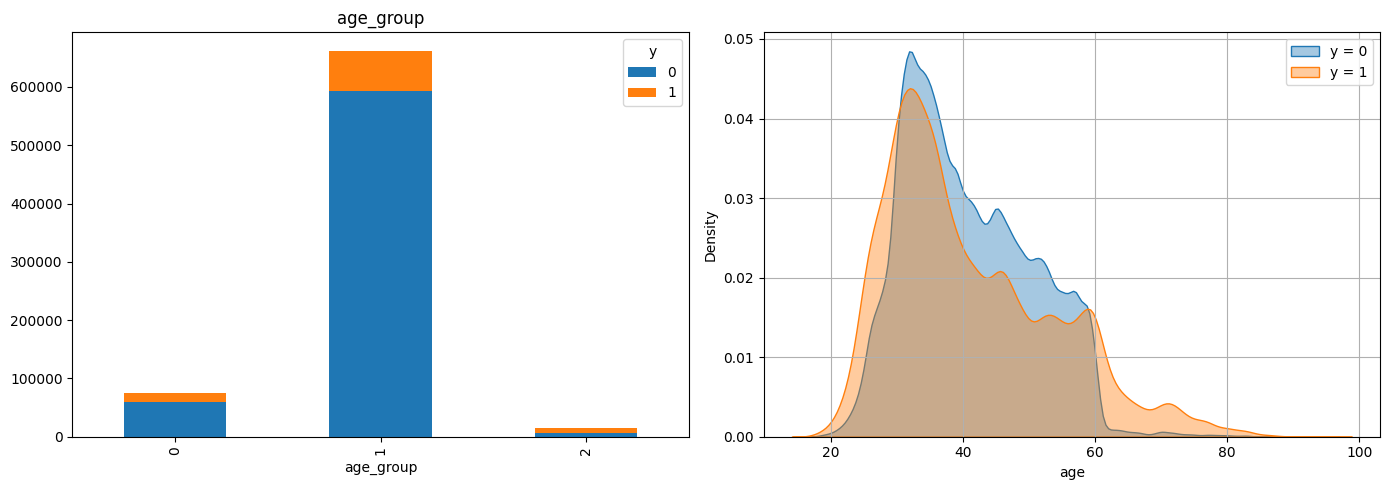

In [157]:
def stability(x):
    if x < 30: 
        return 0
    elif x >= 30 and x <= 60:
        return 1
    else:
        return 2

train_df['age_group'] = train_df['age'].apply(stability)

print('Percentage summary:')
display((pd.crosstab(train_df['age_group'], train_df["y"], normalize='index') * 100).round(1))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
train_df.groupby(['age_group','y']).size().unstack().plot(kind='bar', stacked=True, ax=axes[0], title='age_group')
sns.kdeplot(data=train_df[train_df['y'] == 0], x='age', label='y = 0', fill=True, alpha=0.4, ax=axes[1])
sns.kdeplot(data=train_df[train_df['y'] == 1], x='age', label='y = 1', fill=True, alpha=0.4, ax=axes[1])
plt.tight_layout()
plt.legend()
plt.grid(True)
plt.show()


### Success rate of campaign by month devided into 3 gropus 

Percentage summary:


y,0,1
month_group,,
0,77.6,22.4
1,91.0,9.0
2,80.2,19.8


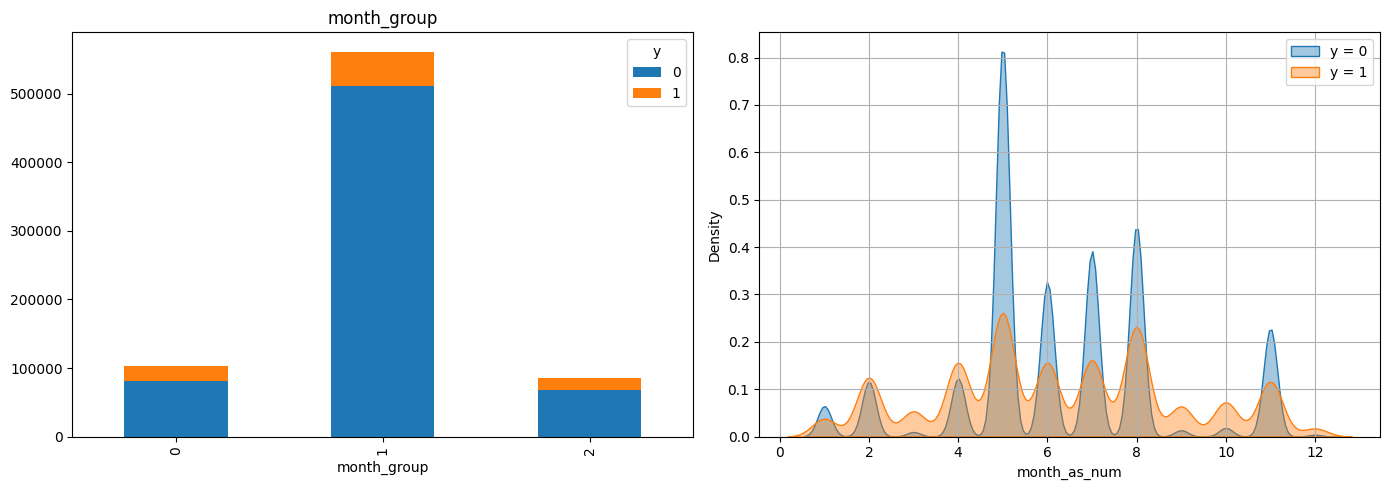

In [158]:
def month(x):
    if x < 5:
        return 0
    elif x >= 5 and x <=8:
        return 1
    else:
        return 2 

train_df['month_group'] = train_df['month_as_num'].apply(month)

print('Percentage summary:')
display((pd.crosstab(train_df['month_group'], train_df["y"], normalize='index') * 100).round(1))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
train_df.groupby(['month_group','y']).size().unstack().plot(kind='bar', stacked=True, ax=axes[0], title='month_group')
sns.kdeplot(data=train_df[train_df['y'] == 0], x='month_as_num', label='y = 0', fill=True, alpha=0.4, ax=axes[1])
sns.kdeplot(data=train_df[train_df['y'] == 1], x='month_as_num', label='y = 1', fill=True, alpha=0.4, ax=axes[1])
plt.tight_layout()
plt.legend()
plt.grid(True)
plt.show()


### Length of last contact devided into 3 groups (short, medium, long)

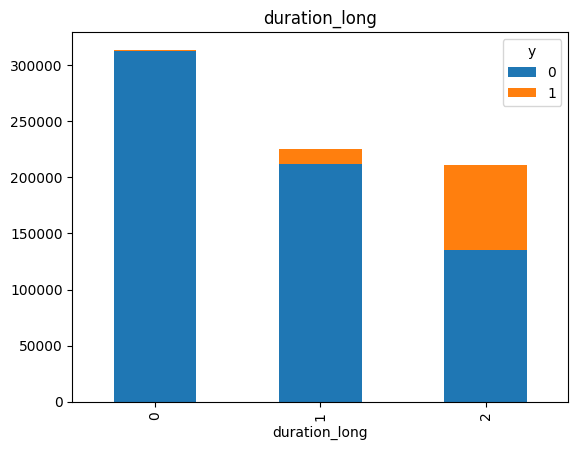

Percentage summary:


y,0,1
duration_long,,
0,99.5,0.5
1,93.9,6.1
2,64.2,35.8


In [159]:
def duration(x):
    # short
    if x < 120:
        return 0
    # medium
    elif x >= 120 and x <=250:
        return 1
    # long
    else:
        return 2

train_df['duration_long'] = train_df['duration'].apply(duration)

train_df.groupby(['duration_long','y']).size().unstack().plot(kind='bar', stacked=True, title='duration_long')
plt.show()
print('Percentage summary:')
display((pd.crosstab(train_df['duration_long'], train_df["y"], normalize='index') * 100).round(1))

### Key Observations:
- Inluence of grouping can be checked with feature importance but most of modern classifiers deal with it efficiently
- It could be usefull for noise reduction and help model learn especially with smaller data sets (in our case we have 750k)
- There is a risk that rare cases will be omitted 

### Additional conditional features

### Number of loans (loan + housing)

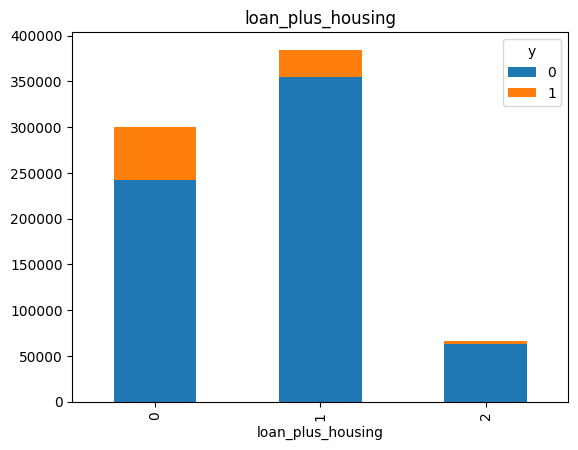

Percentage summary:


y,0,1
loan_plus_housing,,
0,81.0,19.0
1,92.2,7.8
2,95.0,5.0


In [160]:
mapping = ({'yes':1,"no":0})
train_df['loan_code'] = train_df['loan'].map(mapping)
train_df['housing_code'] = train_df['housing'].map(mapping)

train_df['loan_plus_housing'] = (train_df['loan_code']+train_df['housing_code']).astype(int)

train_df.groupby(['loan_plus_housing','y']).size().unstack().plot(kind='bar', stacked=True, title='loan_plus_housing')
plt.show()
print('Percentage summary:')
display((pd.crosstab(train_df['loan_plus_housing'], train_df["y"], normalize='index') * 100).round(1))

### Check if customer is in deep debt - balance below 0 and  loan + housing are true

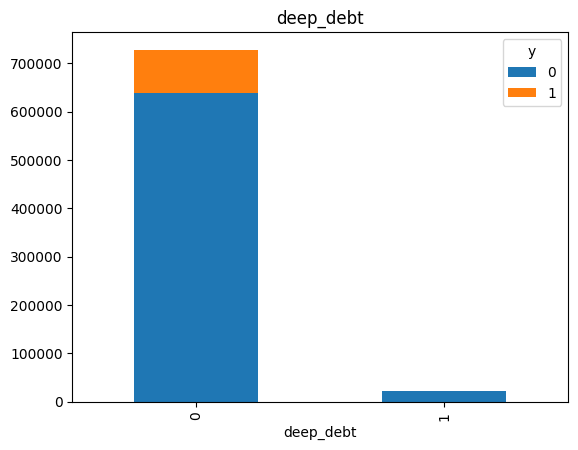

Percentage summary:


y,0,1
deep_debt,,
0,87.7,12.3
1,96.8,3.2


In [161]:
train_df['deep_debt'] = ((train_df['balance'] < 0 ) & (train_df['loan_plus_housing'] == 2)).astype(int)

train_df.groupby(['deep_debt','y']).size().unstack().plot(kind='bar', stacked=True, title='deep_debt')
plt.show()
print('Percentage summary:')
display((pd.crosstab(train_df['deep_debt'], train_df["y"], normalize='index') * 100).round(1))

### Key Observations:
- Having two loans (housing + personal loan) significantly reduces the willingness to take out a new loan (only ~5% of positive responses), which may be a strong predictor in the model.
- Deep overdraft + two loans is a very rare but clearly risky profile – only 3% of customers in this group declare their willingness to take out a loan, which makes this feature a potential high-risk indicator.
- The lack of loans is associated with a much greater openness to new credit (~19% positive responses), suggesting that the number of active loans is an important variable in predicting interest in new credit.